In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import warnings
from scipy.optimize import curve_fit
from scipy import integrate, stats
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)

## Total stock plot

In [3]:
TYP = ['TOT','AB','MFH','SFH','TH']

DSM_AB = pd.read_csv("Model/DSM_model_AB.csv")
DSM_AB = DSM_AB.set_index('Unnamed: 0')
DSM_AB.index.name = 'DSM AB'
DSM_MFH = pd.read_csv("Model/DSM_model_MFH.csv")
DSM_MFH = DSM_MFH.set_index('Unnamed: 0')
DSM_MFH.index.name = 'DSM MFH'
DSM_SFH = pd.read_csv("Model/DSM_model_SFH.csv")
DSM_SFH = DSM_SFH.set_index('Unnamed: 0')
DSM_SFH.index.name = 'DSM SFH'
DSM_TH = pd.read_csv("Model/DSM_model_TH.csv")
DSM_TH = DSM_TH.set_index('Unnamed: 0')
DSM_TH.index.name = 'DSM TH'

display(DSM_TH)

DSM = DSM_AB.copy(deep=True)
DSM['Stock'] = DSM_AB['Stock']+DSM_MFH['Stock']+DSM_SFH['Stock']+DSM_TH['Stock']
DSM['Stock Change'] = DSM_AB['Stock Change']+DSM_MFH['Stock Change']+DSM_SFH['Stock Change']+DSM_TH['Stock Change']
DSM['Inflow'] = DSM_AB['Inflow']+DSM_MFH['Inflow']+DSM_SFH['Stock']+DSM_TH['Inflow']
DSM['Outflow'] = DSM_AB['Outflow']+DSM_MFH['Outflow']+DSM_SFH['Outflow']+DSM_TH['Outflow']
DSM.index.name = 'DSM'

display(DSM)

DSM_all = [DSM,DSM_AB,DSM_MFH,DSM_SFH,DSM_TH]

,Population,Stock,PpD,Stock Change,Inflow,Outflow,Stock change
DSM TH,,,,,,,
1600,0,NaN,0,0,0.000000,NaN,NaN
1601,0,3.172922e+02,0,0,317.292166,0.000000,317.292166
1602,0,6.448160e+02,0,0,329.473430,1.949597,327.523834
1603,0,9.836621e+02,0,0,341.848464,3.002413,338.846051
1604,0,1.333982e+03,0,0,354.415592,4.096002,350.319589
...,...,...,...,...,...,...,...
2046,0,1.326709e+07,0,0,20169.298776,47199.148439,-27029.849663
2047,0,1.323896e+07,0,0,18931.451816,47062.799285,-28131.347469
2048,0,1.320971e+07,0,0,17671.021090,46921.053052,-29250.031962


,Population,Stock,PpD,Stock Change,Inflow,Outflow,Stock change
DSM,,,,,,,
1600,0,NaN,0,0,NaN,NaN,NaN
1601,0,9.164954e+02,0,0,9.164954e+02,0.000000,0.000000
1602,0,1.848435e+03,0,0,1.220263e+03,5.631391,0.000000
1603,0,2.798496e+03,0,0,1.527037e+03,8.585744,0.000000
1604,0,3.766606e+03,0,0,1.836699e+03,11.610937,0.000000
...,...,...,...,...,...,...,...
2046,0,2.678180e+07,0,0,7.272251e+06,96078.615121,8447.844207
2047,0,2.689416e+07,0,0,7.349306e+06,96447.588006,8575.349802
2048,0,2.700745e+07,0,0,7.427476e+06,96817.678436,8703.829994


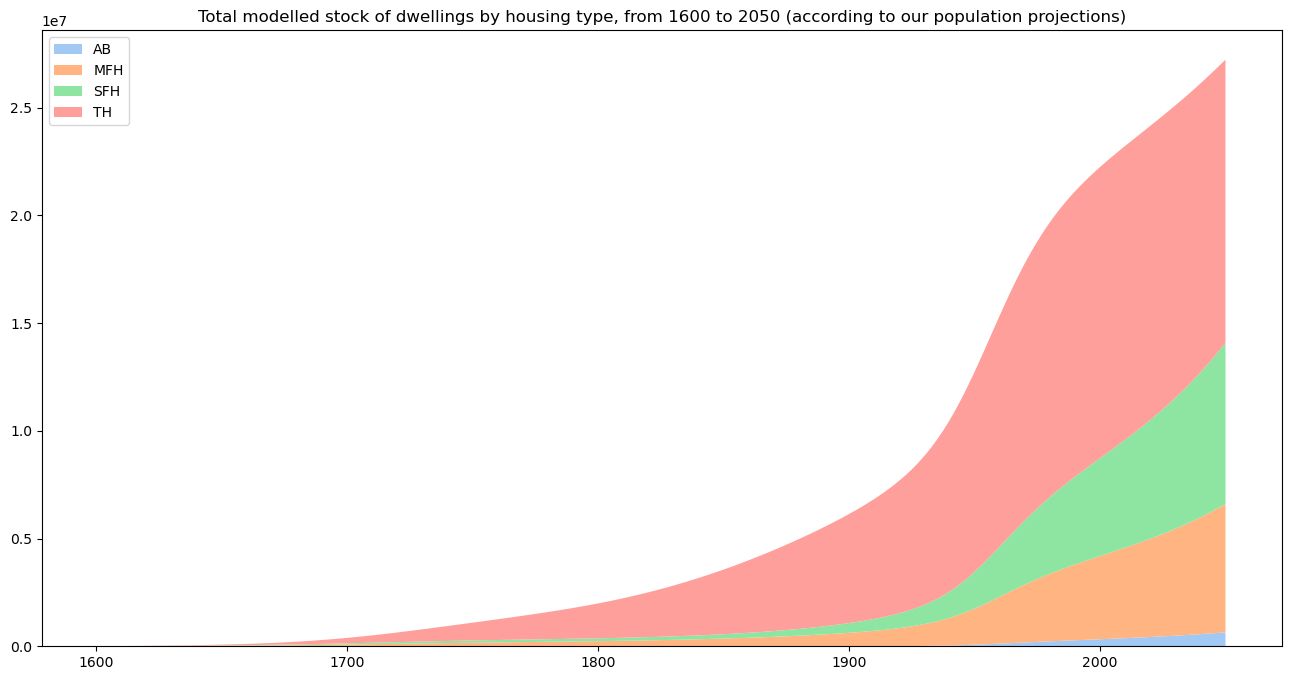

In [4]:
DSM_by_TYP = [dsm['Stock'].to_list() for dsm in DSM_all[1:]]
colors = sns.color_palette('pastel')[0:4]

plt.figure(figsize=(16,8))
plt.stackplot(DSM.index,DSM_by_TYP, labels=TYP[1:], colors=colors)
plt.legend(loc='upper left')
plt.title('Total modelled stock of dwellings by housing type, from 1600 to 2050 (according to our population projections)')
plt.show()

# Raw energy demand for cohort-period corresponding to the years

NB for Scenarios: only upload the csv docs instead of running this:
* `Model/NRJ_AsBuilt_Dwe.csv` 
* `Model/NRJ_StdRfb_Dwe.csv` 
* `Model/NRJ_AmbRfb_Dwe.csv` 

Let's just apply the energy final consumption to the stock, abruptly, without considering the cohorts/inflow/outflow. 

We use the EPISCOPE data.

In [5]:
# Source : EPISCOPE 

file = "Data/EPISCOPE/Eng-energy-efficiency-score_updated.xlsx"
NRJ = pd.read_excel(file)
NRJ.columns = NRJ.loc[0,:]
NRJ = NRJ.drop(index=[0])

arrays = [
    NRJ['type'],
    NRJ['cohorts']
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)#, names=["type", "second"])

NRJ = NRJ.drop(columns=['type','cohorts'])
NRJ.index = index

#display(NRJ)

# Missing values for AB => interpolation 

#print(NRJ.loc[('AB',['pre1919','1919_1944']),'AsBuilt'])

for reno in NRJ.columns:
    NRJ_AB = NRJ.loc['AB',reno]
    NRJ_AB = NRJ_AB.astype(float)
    NRJ_AB.index = [1919,1944,1964,1980,1999,2003,2009,2013]
    #display(NRJ_AB)
    NRJ_AB.interpolate(method='polynomial', order=2,axis=0,inplace=True)
    rate = (NRJ_AB.loc[1980]-NRJ_AB.loc[1964])/(1980-1964)
    NRJ_AB.loc[1944] = NRJ_AB.loc[1964]-rate*(1964-1944)
    NRJ_AB.loc[1919] = NRJ_AB.loc[1964]-rate*(1964-1919)
    rate = (NRJ_AB.loc[2009]-NRJ_AB.loc[2003])/(2009-2003)
    NRJ_AB.loc[2013] = NRJ_AB.loc[2009]+rate*(2013-2009)
    #display(NRJ_AB)
    NRJ.loc[('AB',['pre1919','1919_1944','1945_1964','1965_1980','1981_1990','1991_2003','2004_2009','post2010']),reno] = NRJ_AB.to_list()

# UNIT = kWh/sqm 

# Correcting to strange numbers: 
NRJ.loc[('AB','pre1919'),'Standard_refurbishment'] = 55
NRJ.loc[('AB','1919_1944'),'Standard_refurbishment'] = 55
NRJ.loc[('AB','post2010'),'AsBuilt'] = 42
NRJ.loc[('AB','post2010'),'Standard_refurbishment'] = 42

# Correcting after regression 
NRJ.loc[('SFH','pre1919'),'Ambitious_refurbishment'] = NRJ.loc[('SFH','1919_1944'),'Ambitious_refurbishment']
NRJ.loc[('TH','pre1919'),'Ambitious_refurbishment'] = NRJ.loc[('TH','1919_1944'),'Ambitious_refurbishment']
NRJ.loc[('AB','pre1919'),'Ambitious_refurbishment'] = NRJ.loc[('AB','1919_1944'),'Ambitious_refurbishment']
NRJ.loc[('MFH','pre1919'),'Ambitious_refurbishment'] = NRJ.loc[('MFH','1919_1944'),'Ambitious_refurbishment']
# 
NRJ.loc[('SFH','1919_1944'),'Standard_refurbishment'] = NRJ.loc[('SFH','1945_1964'),'Standard_refurbishment']
NRJ.loc[('SFH','pre1919'),'Standard_refurbishment'] = NRJ.loc[('SFH','1919_1944'),'Standard_refurbishment'] 
NRJ.loc[('TH','1919_1944'),'Standard_refurbishment'] = NRJ.loc[('TH','1945_1964'),'Standard_refurbishment']
NRJ.loc[('TH','pre1919'),'Standard_refurbishment'] = NRJ.loc[('TH','1919_1944'),'Standard_refurbishment'] 
NRJ.loc[('MFH','1919_1944'),'Standard_refurbishment'] = NRJ.loc[('MFH','1945_1964'),'Standard_refurbishment']
NRJ.loc[('MFH','pre1919'),'Standard_refurbishment'] = NRJ.loc[('MFH','1919_1944'),'Standard_refurbishment'] 

display(NRJ)
display(NRJ.loc[('SFH','pre1919')]['AsBuilt'])

0                AsBuilt Standard_refurbishment Ambitious_refurbishment
SFH pre1919        247.3                    103                    83.8
    1919_1944      266.5                    103                    83.8
    1945_1964      259.8                    103                      92
    1965_1980        228                  138.5                    93.7
    1981_1990      166.3                  110.5                    90.2
    1991_2003      143.2                  103.6                    82.9
    2004_2009       69.6                   69.6                    66.3
    post2010        63.7                   47.1                    43.9
TH  pre1919        281.1                  107.9                    85.8
    1919_1944        310                  107.9                    85.8
    1945_1964      281.2                  107.9                    95.9
    1965_1980      221.4                  114.5                      94
    1981_1990        193                  114.2                    95.2
    1991_2003      176.4                  110.7                    92.2
    2004_2009       71.3                   71.3                    68.6
    post2010        64.9                   46.8                    43.6
MFH pre1919        205.5                   82.4                    61.8
    1919_1944      222.4                   82.4                    61.8
    1945_1964      219.1                   82.4                    72.9
    1965_1980      166.5                   85.2                    67.1
    1981_1990      128.4                   74.8                    61.5
    1991_2003      122.4                   81.2                      65
    2004_2009         55                     55                    52.8
    post2010        50.6                     35                    31.8
AB  pre1919     327.0125                     55                   45.05
    1919_1944     242.95                     55                   45.05
    1945_1964      175.7                   56.5                    48.8
    1965_1980      121.9                   70.2                    51.8
    1981_1990  68.159483              60.617193               47.343008
    1991_2003  58.249483              55.023305                45.29523
    2004_2009       44.3                   44.3                    41.5
    post2010          42                     42               38.969847

247.3

In [6]:
# Hyp pour l'instant: 2050 a la même efficacité energétique que mtn 

def Average(lst): 
    return sum(lst) / len(lst) 

def NRJ_fill(reno,NRJ_reno,Nergy):
    for t in NRJ_reno.columns.to_list()[1:]:
        for i in NRJ_reno.index:
            if i < 1919:
                #print('pre1919',i)
                value = Nergy.loc[(t,'pre1919')][reno]
                NRJ_reno.loc[i,t] = value
            elif 1919 <= i <= 1944:
                #print('pre44',i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1919_1944')][reno]
            elif 1945 <= i <= 1964:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1945_1964')][reno]
            elif 1965 <= i <= 1980:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1965_1980')][reno]
            elif 1981 <= i <= 1990:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1981_1990')][reno]
            elif 1991 <= i <= 2003:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1991_2003')][reno]
            elif 2004 <= i <= 2050:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'2004_2009')][reno]
    for i in NRJ_reno.index:
        NRJ_reno.loc[i,'TOT'] = Average(NRJ_reno.loc[i,'AB':'TH'].to_list())
    return NRJ_reno

def NRJ_interpolate(reno,NRJ_reno,Nergy):
    for t in NRJ_reno.columns.to_list()[1:]:
        NRJ_reno.loc[1919,t] = Nergy.loc[(t,'pre1919')][reno]
        NRJ_reno.loc[1944,t] = Nergy.loc[(t,'1919_1944')][reno]
        NRJ_reno.loc[1964,t] = Nergy.loc[(t,'1945_1964')][reno]
        NRJ_reno.loc[1980,t] = Nergy.loc[(t,'1965_1980')][reno]
        NRJ_reno.loc[1990,t] = Nergy.loc[(t,'1981_1990')][reno]
        NRJ_reno.loc[2003,t] = Nergy.loc[(t,'1991_2003')][reno]
        NRJ_reno.loc[2009,t] = Nergy.loc[(t,'2004_2009')][reno]
        #NRJ_reno[t] = NRJ_reno[t].interpolate(method='polynomial', order=2,axis=0,inplace=True)
    #NRJ_reno.interpolate(method='polynomial', order=2,axis=0,inplace=True)
    for i in [1919,1944,1964,1980,1990,2003,2009]:
        NRJ_reno.loc[i,'TOT'] = Average(NRJ_reno.loc[i,'AB':'TH'].to_list())
    return NRJ_reno

def NRJ_extend(NRJ_reno):
    NRJ_reno.loc[1600,:] = NRJ_reno.loc[1919,:]
    NRJ_reno.loc[2050,:] = NRJ_reno.loc[2010,:]
    return NRJ_reno

    

In [7]:
NRJ_AsBuilt = pd.DataFrame(index=np.arange(1600,2051),columns=TYP).astype('float')
NRJ_AsBuilt.index.name = 'cohort'
#NRJ_AsBuilt = NRJ_fill('AsBuilt',NRJ_AsBuilt,NRJ)
NRJ_AsBuilt = NRJ_interpolate('AsBuilt',NRJ_AsBuilt,NRJ)
NRJ_AsBuilt = NRJ_extend(NRJ_AsBuilt)
NRJ_AsBuilt.interpolate(method='linear', axis=0,inplace=True)
#NRJ_AsBuilt.interpolate(method='polynomial', order=2,axis=0,inplace=True)
display(NRJ_AsBuilt.loc[2000:2012,:]) # kWh/sqm 

NRJ_StdRfb = pd.DataFrame(index=np.arange(1600,2051),columns=TYP).astype('float')
NRJ_StdRfb.index.name = 'cohort'
#NRJ_StdRfb = NRJ_fill('Standard_refurbishment',NRJ_StdRfb,NRJ)
NRJ_StdRfb = NRJ_interpolate('Standard_refurbishment',NRJ_StdRfb,NRJ)
NRJ_StdRfb = NRJ_extend(NRJ_StdRfb)
NRJ_StdRfb.interpolate(method='linear', axis=0,inplace=True)
#NRJ_StdRfb.interpolate(method='polynomial', order=2,axis=0,inplace=True)
display(NRJ_StdRfb) # kWh/sqm 

NRJ_AmbRfb = pd.DataFrame(index=np.arange(1600,2051),columns=TYP).astype('float')
NRJ_AmbRfb.index.name = 'cohort'
#NRJ_AmbRfb = NRJ_fill('Ambitious_refurbishment',NRJ_AmbRfb,NRJ)
NRJ_AmbRfb = NRJ_interpolate('Ambitious_refurbishment',NRJ_AmbRfb,NRJ)
NRJ_AmbRfb = NRJ_extend(NRJ_AmbRfb)
NRJ_AmbRfb.interpolate(method='linear', axis=0,inplace=True)
#NRJ_AmbRfb.interpolate(method='polynomial', order=2,axis=0,inplace=True)
display(NRJ_AmbRfb) # kWh/sqm 

,TOT,AB,MFH,SFH,TH
cohort,,,,,
2000,128.270640,60.536406,123.784615,148.530769,180.230769
2001,127.201217,59.774098,123.323077,146.753846,178.953846
2002,126.131794,59.011790,122.861538,144.976923,177.676923
2003,125.062371,58.249483,122.400000,143.200000,176.400000
2004,114.226976,55.924569,111.166667,130.933333,158.883333
2005,103.391580,53.599655,99.933333,118.666667,141.366667
2006,92.556185,51.274741,88.700000,106.400000,123.850000
2007,81.720790,48.949828,77.466667,94.133333,106.333333
2008,70.885395,46.624914,66.233333,81.866667,88.816667


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,87.075,55.0,82.4,103.0,107.9
1601,87.075,55.0,82.4,103.0,107.9
1602,87.075,55.0,82.4,103.0,107.9
1603,87.075,55.0,82.4,103.0,107.9
1604,87.075,55.0,82.4,103.0,107.9
...,...,...,...,...,...
2046,60.050,44.3,55.0,69.6,71.3
2047,60.050,44.3,55.0,69.6,71.3
2048,60.050,44.3,55.0,69.6,71.3


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,69.1125,45.05,61.8,83.8,85.8
1601,69.1125,45.05,61.8,83.8,85.8
1602,69.1125,45.05,61.8,83.8,85.8
1603,69.1125,45.05,61.8,83.8,85.8
1604,69.1125,45.05,61.8,83.8,85.8
...,...,...,...,...,...
2046,57.3000,41.50,52.8,66.3,68.6
2047,57.3000,41.50,52.8,66.3,68.6
2048,57.3000,41.50,52.8,66.3,68.6


In [8]:
def logistic(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    """
    General logistic function.
    Arguments:
    - x: np.ndarray of observation points (time)
    - ti: inflection time
    - tau: transition time coefficient
    - C0: start value
    - C1: end value

    Returns:
    - np.ndarray with len(x) number of points
    """
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0 

/Applications/anaconda3/envs/TEP4221/lib/python3.8/site-packages/pandas/core/indexes/base.py:969: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


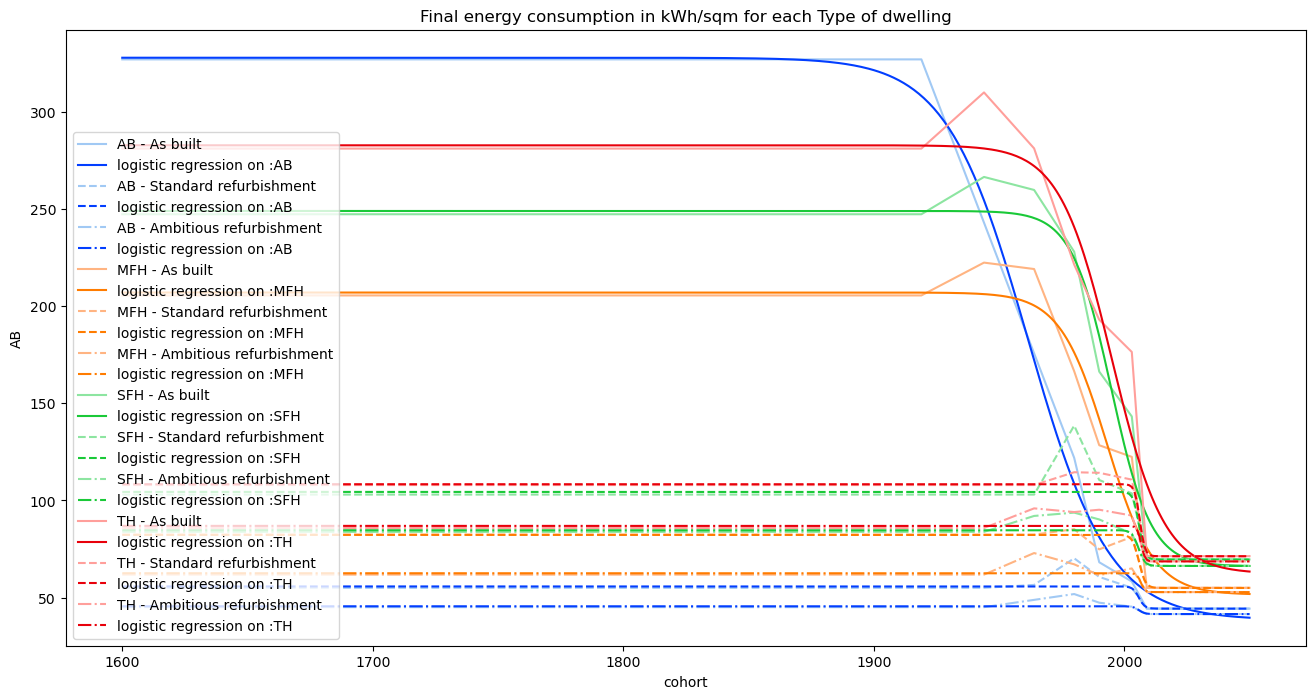

In [9]:
colors = sns.color_palette('pastel')[0:4]
colors_reg = sns.color_palette('bright')[0:4]

plt.figure(figsize=(16,8))
for t in np.arange(4):
    k = TYP[1+t]
    # Raw data
    sns.lineplot(data=NRJ_AsBuilt,x=NRJ_AsBuilt.index,y=k,color=colors[t],label=str(k+' - As built'))
    # Logistic regression
    popt, pcov = curve_fit(logistic, NRJ_AsBuilt.index, NRJ_AsBuilt[k], bounds = ([min(NRJ_AsBuilt.index), 0, 0, 0], [max(NRJ_AsBuilt.index), 400, 400, 400]))
    log_reg_AsBuilt = logistic(NRJ_AsBuilt.index, *popt)
    #print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
    ax = sns.lineplot(y=log_reg_AsBuilt,x=NRJ_AsBuilt.index,color=colors_reg[t],label="logistic regression on :"+k)
    # Changing to the newest data
    NRJ_AsBuilt[k] = log_reg_AsBuilt.astype('float')

    # Raw data
    sns.lineplot(data=NRJ_StdRfb,x=NRJ_StdRfb.index,y=k,color=colors[t],label=k+' - Standard refurbishment',linestyle='dashed')
    # Logistic regression
    popt, pcov = curve_fit(logistic, NRJ_StdRfb.index, NRJ_StdRfb[k], bounds = ([min(NRJ_StdRfb.index), 0, 0, 0], [max(NRJ_StdRfb.index), 400, 400, 400]))
    log_reg_StdRfb = logistic(NRJ_StdRfb.index, *popt)
    #print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
    ax = sns.lineplot(y=log_reg_StdRfb,x=NRJ_StdRfb.index,color=colors_reg[t],label="logistic regression on :"+k,linestyle='dashed')
    # Changing to the newest data
    NRJ_StdRfb[k] = log_reg_StdRfb

    # Raw data 
    sns.lineplot(data=NRJ_AmbRfb,x=NRJ_AmbRfb.index,y=k,color=colors[t],label=k+' - Ambitious refurbishment',linestyle='dashdot')
    # Logistic regression
    popt, pcov = curve_fit(logistic, NRJ_AmbRfb.index, NRJ_AmbRfb[k], bounds = ([min(NRJ_AmbRfb.index), 0, 0, 0], [max(NRJ_AmbRfb.index), 400, 400, 400]))
    log_reg_AmbRfb = logistic(NRJ_AmbRfb.index, *popt)
    #print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
    ax = sns.lineplot(y=log_reg_AmbRfb,x=NRJ_AmbRfb.index,color=colors_reg[t],label="logistic regression on :"+k,linestyle='dashdot')
    # Changing to the newest data
    NRJ_AmbRfb[k] = log_reg_AmbRfb

plt.legend(loc='lower left')
plt.title('Final energy consumption in kWh/sqm for each Type of dwelling')
plt.show()

2050
2050
2050
2050


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,266.667841,327.868515,207.012297,248.995210,282.795341
1601,266.667841,327.868515,207.012297,248.995210,282.795341
1602,266.667841,327.868515,207.012297,248.995210,282.795341
1603,266.667841,327.868515,207.012297,248.995210,282.795341
1604,266.667841,327.868515,207.012297,248.995210,282.795341
...,...,...,...,...,...
2046,55.559178,39.952632,52.008213,66.370004,63.905863
2047,55.475678,39.858683,51.953286,66.336507,63.754238
2048,55.399358,39.770292,51.903888,66.306979,63.616275


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,266.667841,327.868515,207.012297,248.995210,282.795341
1601,266.667841,327.868515,207.012297,248.995210,282.795341
1602,266.667841,327.868515,207.012297,248.995210,282.795341
1603,266.667841,327.868515,207.012297,248.995210,282.795341
1604,266.667841,327.868515,207.012297,248.995210,282.795341
...,...,...,...,...,...
2046,55.559178,39.952632,52.008213,66.370004,63.905863
2047,55.475678,39.858683,51.953286,66.336507,63.754238
2048,55.399358,39.770292,51.903888,66.306979,63.616275


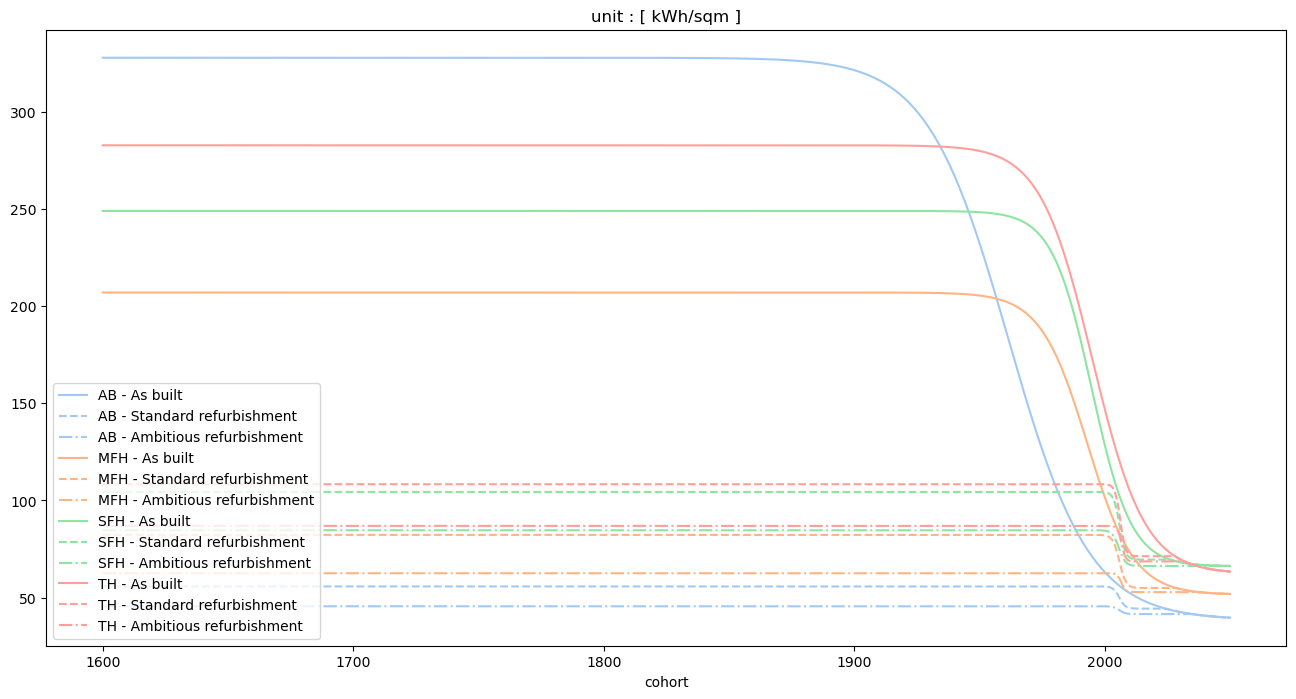

In [19]:
# Lastest years: joining AsBuilt and refurbishments:

for t in TYP[1:]:
    m = 2050
    for i in NRJ_AsBuilt.index:
        if NRJ_StdRfb.loc[i,t] > NRJ_AsBuilt.loc[i,t]:
            m = min(i,m)
            NRJ_StdRfb.loc[i,t] = NRJ_AsBuilt.loc[i,t]
        if NRJ_AmbRfb.loc[i,t] > NRJ_AsBuilt.loc[i,t]:
            m = min(i,m)
            NRJ_AmbRfb.loc[i,t] = NRJ_AsBuilt.loc[i,t]
    print(m)
# 2025 - 2029 - 2027 - 2029 are affected only => no present times, so we can keep this model 

display(NRJ_AsBuilt)

for i in NRJ_AsBuilt.index:
    NRJ_AsBuilt.loc[i,'TOT'] = NRJ_AsBuilt.loc[i,'AB':'TH'].mean()
    NRJ_AmbRfb.loc[i,'TOT'] = NRJ_AmbRfb.loc[i,'AB':'TH'].mean()
    NRJ_StdRfb.loc[i,'TOT'] = NRJ_StdRfb.loc[i,'AB':'TH'].mean()

display(NRJ_AsBuilt)

colors = sns.color_palette('pastel')[0:4]

ax = plt.figure(figsize=(16,8))
for t in np.arange(4):
    k = TYP[1+t]
    sns.lineplot(data=NRJ_AsBuilt,x=NRJ_AsBuilt.index,y=k,color=colors[t],label=str(k+' - As built'))
    sns.lineplot(data=NRJ_StdRfb,x=NRJ_StdRfb.index,y=k,color=colors[t],label=k+' - Standard refurbishment',linestyle='dashed')
    sns.lineplot(data=NRJ_AmbRfb,x=NRJ_AmbRfb.index,y=k,color=colors[t],label=k+' - Ambitious refurbishment',linestyle='dashdot')
#sns.lineplot(data=NRJ_AsBuilt,x=NRJ_AsBuilt.index,y='TOT',color='gray',label='Mean - As built')
#sns.lineplot(data=NRJ_StdRfb,x=NRJ_StdRfb.index,y='TOT',color='gray',label='Mean - Standard refurbishment',linestyle='dashed')
#sns.lineplot(data=NRJ_AmbRfb,x=NRJ_AmbRfb.index,y='TOT',color='gray',label='Mean - Ambitious refurbishment',linestyle='dashdot')
plt.legend(loc='lower left')
plt.title('unit : [ kWh/sqm ]')
plt.ylabel(None)
fig = ax.get_figure()
fig.savefig("Output/Energy/kWh_per_sqm.png",dpi=300,bbox_inches="tight")
plt.show()


# Heated floor



NB for Scenarios: only upload the csv docs instead of running this:
* `Model/NRJ_AsBuilt_Dwe.csv` 
* `Model/NRJ_StdRfb_Dwe.csv` 
* `Model/NRJ_AmbRfb_Dwe.csv` 

,AB,MFH,SFH,TH
pre1919,68.0,70.0,198.00,104.62
1919_1944,59.0,60.0,153.41,93.01
1945_1964,56.0,63.0,134.40,87.72
1965_1980,63.0,62.0,123.08,85.32
1981_1990,68.0,62.0,149.35,98.40
1991_2003,68.0,62.0,149.35,98.40
2004_2009,68.0,62.0,149.35,98.40
post2010,68.0,62.0,149.35,98.40


<AxesSubplot:>

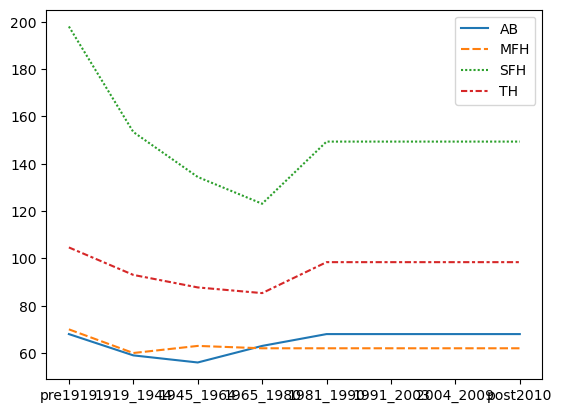

In [11]:
cohorts = ['pre1919','1919_1944','1945_1964','1965_1980','1981_1990','1991_2003','2004_2009','post2010']
time = [1919,1944,1964,1980,1990,2003,2009,2010]
Heated_floor = pd.DataFrame(index=TYP[1:],columns=cohorts)

Heated_floor['pre1919'] = [68,70,198,104.62] # m2
Heated_floor['1919_1944'] = [59,60,153.41,93.01] # m2
Heated_floor['1945_1964'] = [56,63,134.4,87.72] # m2
Heated_floor['1965_1980'] = [63,62,123.08,85.32] # m2
Heated_floor['1981_1990'] = [68,62,149.35,98.4] # m2
Heated_floor['1991_2003'] = [68,62,149.35,98.4] # m2
Heated_floor['2004_2009'] = [68,62,149.35,98.4] # m2
Heated_floor['post2010'] = [68,62,149.35,98.4] # m2

Heated_floor = Heated_floor.T
display(Heated_floor)

sns.lineplot(data=Heated_floor)

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,NaN,80.000000,80.000000,200.000000,120.000000
1601,NaN,79.982802,79.962007,199.995592,119.975031
1602,NaN,79.965951,79.924782,199.991272,119.950565
1603,NaN,79.949448,79.888324,199.987042,119.926605
1604,NaN,79.933292,79.852634,199.982901,119.903149
...,...,...,...,...,...
2046,NaN,67.998173,61.999948,149.338745,98.394490
2047,NaN,67.998592,61.999960,149.341324,98.395753
2048,NaN,67.999036,61.999972,149.344060,98.397092


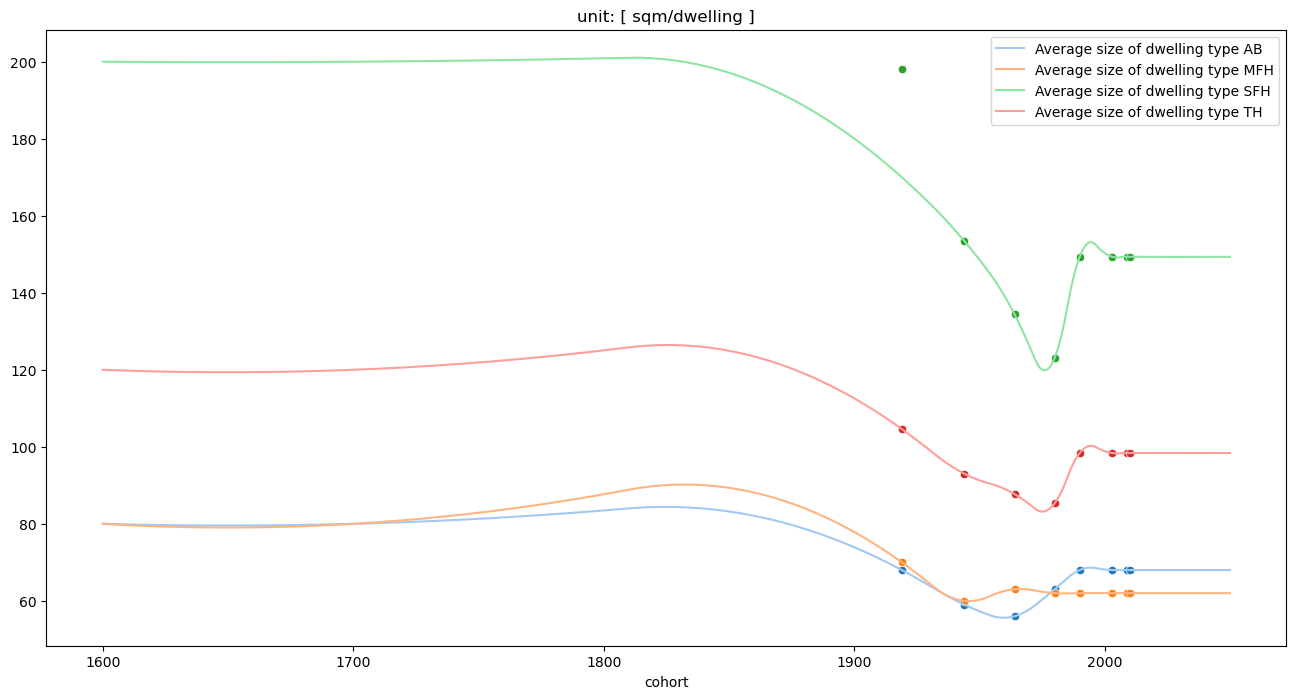

In [20]:
Heated_Area = pd.DataFrame(index=np.arange(1600,2051),columns=TYP).astype('float')
Heated_Area.index.name = 'cohort'

for t in Heated_Area.columns.to_list()[1:]:
    Heated_Area.loc[1919,t] = Heated_floor.loc['pre1919',t]
    Heated_Area.loc[1944,t] = Heated_floor.loc['1919_1944',t]
    Heated_Area.loc[1964,t] = Heated_floor.loc['1945_1964',t]
    Heated_Area.loc[1980,t] = Heated_floor.loc['1965_1980',t]
    Heated_Area.loc[1990,t] = Heated_floor.loc['1981_1990',t]
    Heated_Area.loc[2003,t] = Heated_floor.loc['1991_2003',t]
    Heated_Area.loc[2009,t] = Heated_floor.loc['2004_2009',t]
    Heated_Area.loc[2010,t] = Heated_floor.loc['post2010',t]

Heated_Area = NRJ_extend(Heated_Area)
#NRJ_AmbRfb.interpolate(method='linear', axis=0,inplace=True)
# Adding points to have an interesting interpolation enough
Heated_Area.loc[1600,'AB':'TH'] = [80,80,200,120]
Heated_Area.loc[1700,'AB':'TH'] = [80,80,200,120]
# Changing points to have an interesting interpolation enough
Heated_Area.loc[1919,'SFH'] = 170
Heated_Area.interpolate(method='polynomial', order=2,axis=0,inplace=True,limit_area='inside')
display(Heated_Area)

colors = sns.color_palette('pastel')[0:4]

ax = plt.figure(figsize=(16,8))
sns.scatterplot(data=Heated_floor,x=time,y='AB')
sns.scatterplot(data=Heated_floor,x=time,y='MFH')
sns.scatterplot(data=Heated_floor,x=time,y='SFH')
sns.scatterplot(data=Heated_floor,x=time,y='TH')
for t in np.arange(4):
    k = TYP[1+t]
    sns.lineplot(data=Heated_Area,y=k,x=Heated_Area.index,label='Average size of dwelling type '+k,color=colors[t])
plt.title('unit: [ sqm/dwelling ]')
plt.legend(loc='upper right')
plt.ylabel(None)
fig = ax.get_figure()
fig.savefig("Output/Energy/sqm-per-type.png",dpi=300,bbox_inches="tight")
plt.show()


In [13]:
for i in Heated_Area.index:
    Heated_Area.loc[i,'TOT'] = np.mean([Heated_Area.loc[i,t] for t in TYP[1:]])
display(Heated_Area)

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,120.000000,80.000000,80.000000,200.000000,120.000000
1601,119.978858,79.982802,79.962007,199.995592,119.975031
1602,119.958143,79.965951,79.924782,199.991272,119.950565
1603,119.937855,79.949448,79.888324,199.987042,119.926605
1604,119.917994,79.933292,79.852634,199.982901,119.903149
...,...,...,...,...,...
2046,94.432839,67.998173,61.999948,149.338745,98.394490
2047,94.433907,67.998592,61.999960,149.341324,98.395753
2048,94.435040,67.999036,61.999972,149.344060,98.397092


# Total energy demand

NB for Scenarios: only upload the csv docs instead of running this:
* `Model/NRJ_AsBuilt_Dwe.csv` 
* `Model/NRJ_StdRfb_Dwe.csv` 
* `Model/NRJ_AmbRfb_Dwe.csv` 

In [14]:
display(Heated_Area) #sqm/dwelling by type 
display(NRJ_AsBuilt) # kWh/sqm by type
display(NRJ_StdRfb) # kWh/sqm by type
display(NRJ_AmbRfb) # kWh/sqm by type

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,120.000000,80.000000,80.000000,200.000000,120.000000
1601,119.978858,79.982802,79.962007,199.995592,119.975031
1602,119.958143,79.965951,79.924782,199.991272,119.950565
1603,119.937855,79.949448,79.888324,199.987042,119.926605
1604,119.917994,79.933292,79.852634,199.982901,119.903149
...,...,...,...,...,...
2046,94.432839,67.998173,61.999948,149.338745,98.394490
2047,94.433907,67.998592,61.999960,149.341324,98.395753
2048,94.435040,67.999036,61.999972,149.344060,98.397092


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,266.667841,327.868515,207.012297,248.995210,282.795341
1601,266.667841,327.868515,207.012297,248.995210,282.795341
1602,266.667841,327.868515,207.012297,248.995210,282.795341
1603,266.667841,327.868515,207.012297,248.995210,282.795341
1604,266.667841,327.868515,207.012297,248.995210,282.795341
...,...,...,...,...,...
2046,55.559178,39.952632,52.008213,66.370004,63.905863
2047,55.475678,39.858683,51.953286,66.336507,63.754238
2048,55.399358,39.770292,51.903888,66.306979,63.616275


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,87.674294,55.719340,82.264383,104.372984,108.340471
1601,87.674294,55.719340,82.264383,104.372984,108.340471
1602,87.674294,55.719340,82.264383,104.372984,108.340471
1603,87.674294,55.719340,82.264383,104.372984,108.340471
1604,87.674294,55.719340,82.264383,104.372984,108.340471
...,...,...,...,...,...
2046,55.559178,39.952632,52.008213,66.370004,63.905863
2047,55.475678,39.858683,51.953286,66.336507,63.754238
2048,55.399358,39.770292,51.903888,66.306979,63.616275


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,69.892675,45.504731,62.512542,84.659275,86.894152
1601,69.892675,45.504731,62.512542,84.659275,86.894152
1602,69.892675,45.504731,62.512542,84.659275,86.894152
1603,69.892675,45.504731,62.512542,84.659275,86.894152
1604,69.892675,45.504731,62.512542,84.659275,86.894152
...,...,...,...,...,...
2046,55.532155,39.952632,52.008213,66.261914,63.905863
2047,55.457030,39.858683,51.953286,66.261914,63.754238
2048,55.388092,39.770292,51.903888,66.261914,63.616275


In [15]:
NRJ_AsBuilt_Dwe = NRJ_AsBuilt*Heated_Area/1000
NRJ_AsBuilt_Dwe.index.name = 'cohort'
NRJ_StdRfb_Dwe = NRJ_StdRfb*Heated_Area/1000
NRJ_StdRfb_Dwe.index.name = 'cohort'
NRJ_AmbRfb_Dwe = NRJ_AmbRfb*Heated_Area/1000
NRJ_AmbRfb_Dwe.index.name = 'cohort'

display(NRJ_AsBuilt_Dwe) # MWh/dwelling by type 
display(NRJ_StdRfb_Dwe) # MWh/dwelling by type 
display(NRJ_AmbRfb_Dwe) # MWh/dwelling by type 

NRJ_AsBuilt_Dwe.to_csv("Model/NRJ_AsBuilt_Dwe.csv")
NRJ_StdRfb_Dwe.to_csv("Model/NRJ_StdRfb_Dwe.csv")
NRJ_AmbRfb_Dwe.to_csv("Model/NRJ_AmbRfb_Dwe.csv")

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,32.000141,26.229481,16.560984,49.799042,33.935441
1601,31.994503,26.223842,16.553119,49.797944,33.928380
1602,31.988979,26.218318,16.545413,49.796869,33.921461
1603,31.983569,26.212907,16.537865,49.795816,33.914685
1604,31.978273,26.207610,16.530477,49.794785,33.908052
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,10.520915,4.457547,6.581151,20.874597,13.000856
1601,10.519062,4.456589,6.578025,20.874137,12.998151
1602,10.517246,4.455650,6.574963,20.873686,12.995501
1603,10.515467,4.454730,6.571964,20.873244,12.992905
1604,10.513726,4.453830,6.569028,20.872812,12.990364
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,8.387121,3.640378,5.001003,16.931855,10.427298
1601,8.385643,3.639596,4.998628,16.931482,10.425128
1602,8.384195,3.638829,4.996301,16.931116,10.423003
1603,8.382777,3.638078,4.994022,16.930758,10.420921
1604,8.381389,3.637343,4.991791,16.930407,10.418882
...,...,...,...,...,...
2046,5.244059,2.716706,3.224506,9.895471,6.287985
2047,5.237024,2.710334,3.221102,9.895642,6.273146
2048,5.230577,2.704341,3.218040,9.895823,6.259656


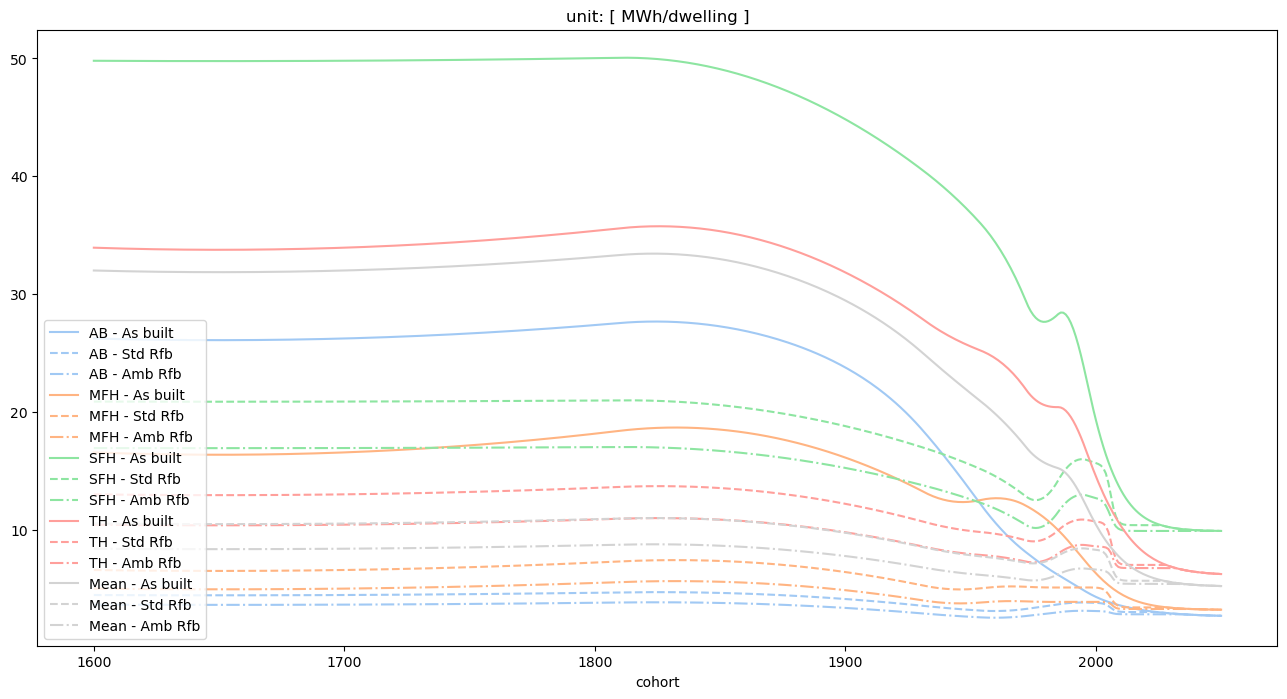

5.9010601897836965


In [21]:
colors = sns.color_palette('pastel')[0:4]

ax = plt.figure(figsize=(16,8))
for t in np.arange(4):
    k = TYP[1+t]
    sns.lineplot(data=NRJ_AsBuilt_Dwe,x=NRJ_AsBuilt_Dwe.index,y=k,color=colors[t],label=str(k+' - As built'))
    sns.lineplot(data=NRJ_StdRfb_Dwe,x=NRJ_StdRfb_Dwe.index,y=k,color=colors[t],label=str(k+' - Std Rfb'),linestyle='dashed')
    sns.lineplot(data=NRJ_AmbRfb_Dwe,x=NRJ_AmbRfb_Dwe.index,y=k,color=colors[t],label=str(k+' - Amb Rfb'),linestyle='dashdot')
sns.lineplot(data=NRJ_AsBuilt_Dwe,x=NRJ_AsBuilt_Dwe.index,y='TOT',color='lightgray',label=str('Mean - As built'))
sns.lineplot(data=NRJ_StdRfb_Dwe,x=NRJ_StdRfb_Dwe.index,y='TOT',color='lightgray',label=str('Mean - Std Rfb'),linestyle='dashed')
sns.lineplot(data=NRJ_AmbRfb_Dwe,x=NRJ_AmbRfb_Dwe.index,y='TOT',color='lightgray',label=str('Mean - Amb Rfb'),linestyle='dashdot')
plt.legend(loc='lower left')
plt.title('unit: [ MWh/dwelling ]')
plt.ylabel(None)
fig = ax.get_figure()
fig.savefig("Output/Energy/MWh_per_dwelling_AsBuilt.png",dpi=300,bbox_inches="tight")
plt.show()

print(NRJ_AsBuilt_Dwe.loc[2023,'TOT'])

Ofgem.gov.uk: "We estimate the typical household in England, Scotland and Wales uses 2,700 kWh of electricity and 11,500 kWh of gas in a year."

In [23]:
def MWh_to_ktoe(MWh):
    ktoe = (MWh/11.63)/1000
    return ktoe

def ktoe_to_MWh(ktoe):
    MWh = 11.63*ktoe
    return MWh 

In [24]:
display(NRJ_AsBuilt_Dwe)

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,32.000141,26.229481,16.560984,49.799042,33.935441
1601,31.994503,26.223842,16.553119,49.797944,33.928380
1602,31.988979,26.218318,16.545413,49.796869,33.921461
1603,31.983569,26.212907,16.537865,49.795816,33.914685
1604,31.978273,26.207610,16.530477,49.794785,33.908052
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


# To the cohort/time tables

In [25]:
file = "Model/stock_AB.csv"
cohort_AB = pd.read_csv(file)
cohort_AB = cohort_AB.set_index('Time ↓ \ Cohort →')

file = "Model/stock_MFH.csv"
cohort_MFH = pd.read_csv(file)
cohort_MFH = cohort_MFH.set_index('Time ↓ \ Cohort →')

file = "Model/stock_SFH.csv"
cohort_SFH = pd.read_csv(file)
cohort_SFH = cohort_SFH.set_index('Time ↓ \ Cohort →')

file = "Model/stock_TH.csv"
cohort_TH = pd.read_csv(file)
cohort_TH = cohort_TH.set_index('Time ↓ \ Cohort →')

cohort_all = [cohort_AB,cohort_MFH,cohort_SFH,cohort_TH]

# Setting to zero the (very small) vegative numbers

for co in cohort_all:
    for i in co.index:
        for j in co.columns:
            co.loc[i,j] = max(0,co.loc[i,j])

display(cohort_AB)

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Time ↓ \ Cohort →,,,,,,,,,,,,,,,,,,,,,
1600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,0,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,0,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000


In [26]:
for co in cohort_all:
    co.columns = co.columns.astype('int')
print(cohort_AB.columns)
print(cohort_AB.index)

Int64Index([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609,
            ...
            2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050],
           dtype='int64', length=451)
Int64Index([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609,
            ...
            2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050],
           dtype='int64', name='Time ↓ \ Cohort →', length=451)


In [27]:
cohort_ED_AB = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_AB.index.name = 'time'
cohort_ED_MFH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_MFH.index.name = 'time'
cohort_ED_SFH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_SFH.index.name = 'time'
cohort_ED_TH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_TH.index.name = 'time'
display(cohort_ED_AB)

cohort_ED_all = [cohort_ED_AB,cohort_ED_MFH,cohort_ED_SFH,cohort_ED_TH]
#print(TYP)

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def fill_cohort_ED_to_zeros(cohort_ED):
    for c in cohort_ED.columns:
        for i in cohort_ED.index:
            cohort_ED.loc[i,c] = 0
    return cohort_ED

def fill_cohort_ED(k,cohort_TYP,NRJ_Dwe,cohort_ED):
    for c in cohort_TYP.columns:
        for i in cohort_TYP.index:
            cohort_ED.loc[i,c] += cohort_TYP.loc[i,c]*NRJ_Dwe.loc[c,k]
    return cohort_ED

In [29]:
display(NRJ_AsBuilt_Dwe.loc[1600,'AB'])

for t in np.arange(4):
    k = TYP[1+t]
    cohort_TYP = cohort_all[t]
    cohort_ED = cohort_ED_all[t]
    cohort_ED = fill_cohort_ED_to_zeros(cohort_ED)
    cohort_ED = fill_cohort_ED(k,cohort_TYP,NRJ_AsBuilt_Dwe,cohort_ED)
    cohort_ED_all[t] = cohort_ED

cohort_ED_AB = cohort_ED_all[0]
cohort_ED_MFH = cohort_ED_all[1]
cohort_ED_SFH = cohort_ED_all[2]
cohort_ED_TH = cohort_ED_all[3]

26.229481220991502

In [30]:
display(cohort_ED_SFH)

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,14164.520813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,14077.487139,14358.751362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,14033.828756,14270.524241,14547.810999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,13990.079469,14226.267194,14458.422205,14731.747587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,5505.984496,5581.696466,5655.409667,5727.142832,5796.914666,5864.743841,5930.649005,5994.648772,6056.761734,...,930059.752594,945197.876436,960610.507284,976291.045514,992233.667858,1011537.510217,0.0,0.0,0.0,0.0
2047,0.0,5505.781431,5581.485137,5655.18987,5726.91436,5796.677309,5864.497388,5930.393241,5994.38348,6056.486693,...,927115.752506,942221.006897,957600.45758,973247.539871,989156.462602,1005322.133985,1024885.313592,0.0,0.0,0.0
2048,0.0,5505.583644,5581.279287,5654.975758,5726.691784,5796.446063,5864.257265,5930.144029,5994.124968,6056.218664,...,924166.377661,939238.511719,954584.52652,970197.892332,986072.850098,1002204.337589,1018587.921994,1038406.452511,0.0,0.0


In [31]:
NRJ_AsBuilt_Time = pd.DataFrame(index=NRJ_AsBuilt_Dwe.index,columns=NRJ_AsBuilt_Dwe.columns)
NRJ_AsBuilt_Time.index.name = 'time'
display(NRJ_AsBuilt_Time)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN


In [32]:
for t in np.arange(4):
    k = TYP[1+t]
    cohort_ED = cohort_ED_all[t]
    for i in NRJ_AsBuilt_Time.index:
        total_ED_TYP = cohort_ED.loc[i,:].sum()
        NRJ_AsBuilt_Time.loc[i,k] = total_ED_TYP
t = 'TOT'
for i in NRJ_AsBuilt_Time.index:
    NRJ_AsBuilt_Time.loc[i,t] = NRJ_AsBuilt_Time.loc[i,'AB']+NRJ_AsBuilt_Time.loc[i,'MFH']+NRJ_AsBuilt_Time.loc[i,'SFH']+NRJ_AsBuilt_Time.loc[i,'TH']

In [33]:
# Convert MWh to ktoe 

display(NRJ_AsBuilt_Time)
NRJ_AsBuilt_Time_ktoe = NRJ_AsBuilt_Time.copy(deep=True)

for i in NRJ_AsBuilt_Time_ktoe.index:
    for k in NRJ_AsBuilt_Time_ktoe.columns:
        ktoe = MWh_to_ktoe(NRJ_AsBuilt_Time.loc[i,k])
        NRJ_AsBuilt_Time_ktoe.loc[i,k] = ktoe
display(NRJ_AsBuilt_Time_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,30140.045105,0.0,5210.315188,14164.520813,10765.209104
1602,60780.233658,0.0,10468.712555,28436.238501,21875.282602
1603,92008.418731,0.0,15789.142105,42852.163996,33367.11263
1604,123822.072505,0.0,21169.836084,57406.516455,45245.719966
...,...,...,...,...,...
2046,546257110.820697,3604903.55372,49239731.644271,165488887.649164,327923587.973542
2047,545731783.431098,3620481.478407,49303808.09797,165896640.286495,326910853.568225
2048,545218922.025974,3636367.629655,49370658.168472,166316447.989916,325895448.237931


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,46969.656992,309.965912,4233.854828,14229.483031,28196.353222
2047,46924.486967,311.305372,4239.364411,14264.543447,28109.273738
2048,46880.388824,312.671335,4245.112482,14300.640412,28021.964595


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,46969.656992,309.965912,4233.854828,14229.483031,28196.353222
2047,46924.486967,311.305372,4239.364411,14264.543447,28109.273738
2048,46880.388824,312.671335,4245.112482,14300.640412,28021.964595


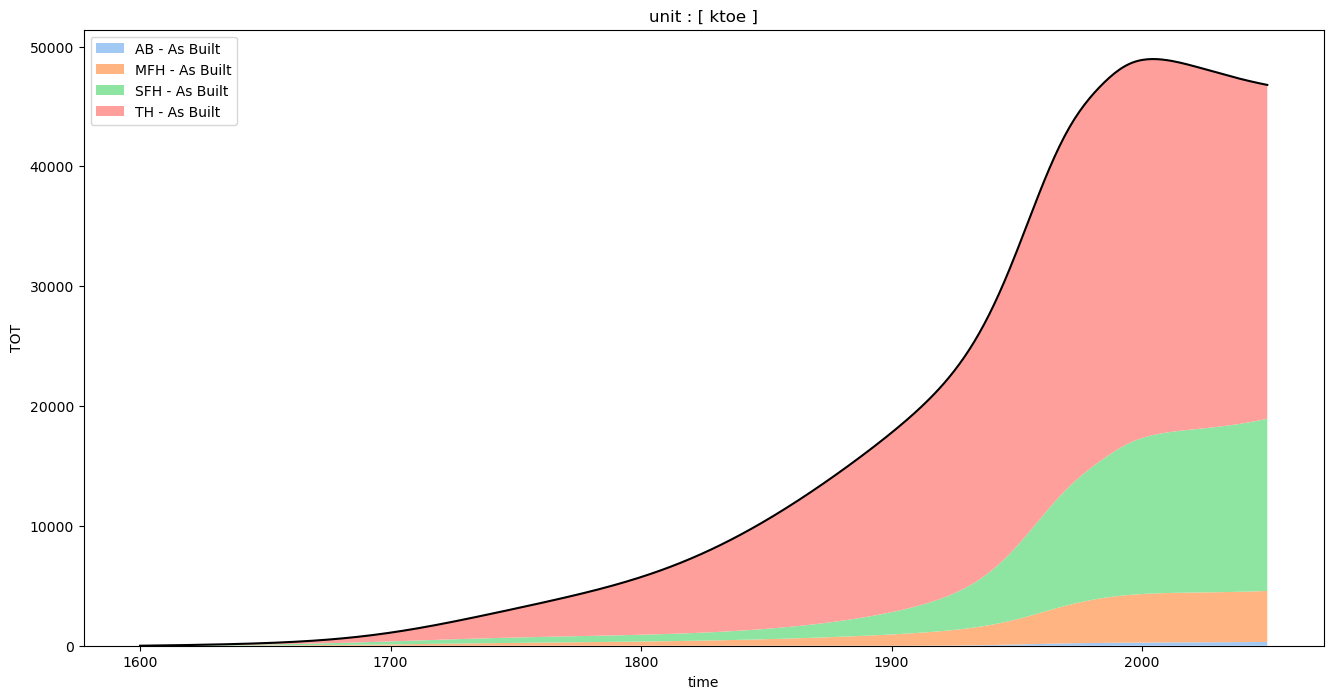

In [34]:
display(NRJ_AsBuilt_Time_ktoe)

def display_NRJ(NRJ_Time_Table,unit,state,save_file=None,T=TYP):
    stack_NRJ_Time_Table = [NRJ_Time_Table[k].to_list() for k in T[1:]]
    lab = [str(k+state) for k in T[1:]]
    colors = sns.color_palette('pastel')[0:4]
    ax = plt.figure(figsize=(16,8))
    plt.stackplot(NRJ_Time_Table.index,stack_NRJ_Time_Table, labels=lab, colors=colors)
    sns.lineplot(data=NRJ_Time_Table,x=NRJ_Time_Table.index,y='TOT',color='black')
    plt.title('unit : [ '+unit+' ]')
    if type(save_file)==str:
        fig = ax.get_figure()
        fig.savefig("Output/"+save_file,dpi=300,bbox_inches="tight")
    plt.show()
    return

def display_NRJ_xlim(NRJ_Time_Table,unit,state,start,end,save_file=None,T=TYP):
    stack_NRJ_Time_Table = [NRJ_Time_Table[k].to_list() for k in T[1:]]
    lab = [str(k+state) for k in T[1:]]
    colors = sns.color_palette('pastel')[0:4]
    ax = plt.figure(figsize=(16,8))
    plt.stackplot(NRJ_Time_Table.index,stack_NRJ_Time_Table, labels=lab, colors=colors)
    sns.lineplot(data=NRJ_Time_Table,x=NRJ_Time_Table.index,y='TOT',color='black')
    plt.title('unit : [ '+unit+' ]')
    if type(save_file)==str:
        fig = ax.get_figure()
        fig.savefig("Output/"+save_file,dpi=300,bbox_inches="tight")
    plt.xlim(start,end)
    return

display_NRJ(NRJ_AsBuilt_Time_ktoe,'ktoe',' - As Built','Energy/ktoe_per_type_AsBuilt.png')

In [35]:
MTOE_data = 35000
print(MTOE_data)
# FULL ENERGY CONSUMPTION SO SHOULD BE EVEN LOWER 
print(NRJ_AsBuilt_Time_ktoe.loc[2012,'TOT'])

35000
48791.089806476724


# Intput all different energy sources 

In [36]:
# Energy sources differe from the location https://www.ons.gov.uk/peoplepopulationandcommunity/housing/articles/census2021howhomesareheatedinyourarea/2023-01-05
# But we will keep an average only 
# Dataset : https://www.ons.gov.uk/filters/710652b0-071a-4a46-8f6b-1554b4e159f1/dimensions

"""
file = "Data/ONS/central-heating.csv"
central_heating = pd.read_csv(file)
central_heating = central_heating[central_heating['Countries']=='England']
central_heating = central_heating.drop(columns=['Countries Code'])
central_heating = central_heating.drop(columns=['Countries'])
central_heating = central_heating.drop(columns=['Type of central heating in household (13 categories) Code'])
central_heating = central_heating.set_index('Type of central heating in household (13 categories)')

display(central_heating)
"""

# https://assets.publishing.service.gov.uk/media/6604334f91a320001182b0de/Energy_Trends_March_2024.pdf
# Source : https://assets.publishing.service.gov.uk/media/6581cb5aed3c34000d3bfbfc/UK_Energy_in_Brief_2023.pdf

'\nfile = "Data/ONS/central-heating.csv"\ncentral_heating = pd.read_csv(file)\ncentral_heating = central_heating[central_heating[\'Countries\']==\'England\']\ncentral_heating = central_heating.drop(columns=[\'Countries Code\'])\ncentral_heating = central_heating.drop(columns=[\'Countries\'])\ncentral_heating = central_heating.drop(columns=[\'Type of central heating in household (13 categories) Code\'])\ncentral_heating = central_heating.set_index(\'Type of central heating in household (13 categories)\')\n\ndisplay(central_heating)\n'

[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966), (0.9873125720876587, 0.6473663975394078, 0.3642445213379469), (0.9971549404075356, 0.9118031526336025, 0.6010765090349866), (0.9288735101883892, 0.9715494040753557, 0.6380622837370243), (0.6334486735870821, 0.8521337946943485, 0.6436755094194541), (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]
[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966), (0.9427942677547513, 0.942825384792593, 0.9519953287278279), (0.9873125720876587, 0.6473663975394078, 0.3642445213379469), (0.9971549404075356, 0.9118031526336025, 0.6010765090349866), (0.9288735101883892, 0.9715494040753557, 0.6380622837370243), (0.6334486735870821, 0.8521337946943485, 0.6436755094194541), (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]
[0.8417849898580121, 0.09432048681541584, 0.044624746450304266, 0.009127789046653146, 0.0030425963488843813, 0.007099391480730222]


,Gas,Electricity,Oil,Coal,Wood,LPG
Shares,0.841785,0.09432,0.044625,0.009128,0.003043,0.007099


[]

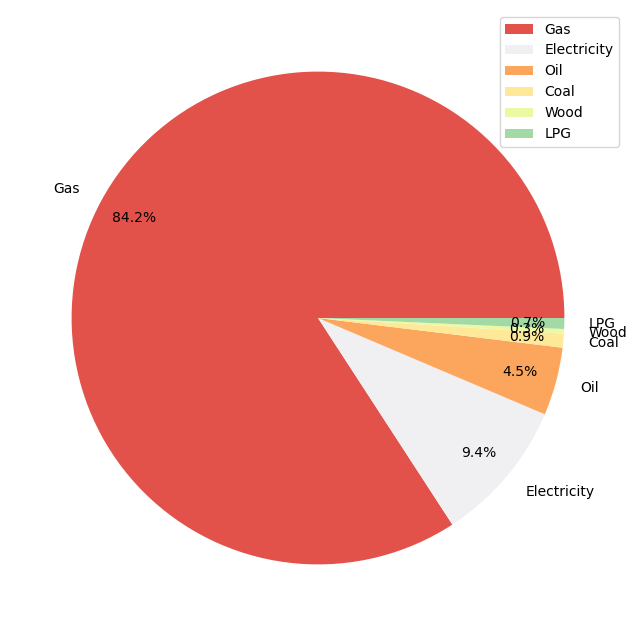

In [37]:
# Source is a research paper (2016): Mapping household direct energy consumption in the United Kingdom to provide a new perspective on energy justice
# Written by : T.J. Chatterton a,∗, J. Anable b, J. Barnes a, G. Yeboah c

colors = sns.color_palette("Spectral")[0:7]
print(colors)
gray = sns.color_palette("light:b")[0]
colors_ED = [colors[0]]+[gray]+colors[1:6]
print(colors_ED)

NRJ_final = ['Gas','Electricity','Oil','Coal','Wood','LPG'] # We are omitting the (little) category 'imports'
NRJ_final_shares = [83/100,9.3/100,4.4/100,0.9/100,0.3/100,0.7/100]
NRJ_total = sum(NRJ_final_shares)
for i in np.arange(len(NRJ_final_shares)):
    NRJ_final_shares[i] = NRJ_final_shares[i]/NRJ_total
print(NRJ_final_shares)

NRJ_final_shares = pd.DataFrame(data=NRJ_final_shares,columns=['Shares'],index=NRJ_final).T
display(NRJ_final_shares)

ax = plt.figure(figsize=(8,8))
plt.pie(NRJ_final_shares.loc['Shares',:],labels=NRJ_final_shares.columns,autopct = '%1.1f%%',pctdistance = 0.85,colors=colors_ED)
plt.legend()
fig = ax.get_figure()
fig.savefig("Output/Energy/heating-dwellings-uk-mix.png",dpi=300,bbox_inches="tight")
plt.plot()

# https://www.nao.org.uk/wp-content/uploads/2024/03/Decarbonising-home-heating-HC-581-SUMMARY.pdf
# 18% of the UK’s greenhouse gas emissions in 2021 (the most recent year for which data are available) were from heating homes

# https://publications.parliament.uk/pa/cm5802/cmselect/cmbeis/1038/report.html

# https://assets.publishing.service.gov.uk/media/6424b8b83d885d000fdade9b/2022_Provisional_emissions_statistics_report.pdf 
# LOOK HERE FOR THE EMISSIONS OF RSIDENTIAL SECTOR

,Other renewables,Hydropower,Solar,Wind,Nuclear,Oil,Gas,Coal
Year,,,,,,,,
1920,0.000000,0.012,0.00,0.00,0.00,0.016422,0.00,3.956950
1921,0.000000,0.010,0.00,0.00,0.00,0.103201,0.00,3.501464
1922,0.000000,0.010,0.00,0.00,0.00,0.057424,0.00,4.167560
1923,0.000000,0.013,0.00,0.00,0.00,0.070453,0.00,4.856229
1924,0.000000,0.015,0.00,0.00,0.00,0.076068,0.00,5.548004
...,...,...,...,...,...,...,...,...
2018,34.989998,5.440,12.67,56.91,65.06,9.340000,131.49,16.830000
2019,37.410000,5.930,12.42,63.84,56.18,9.200000,131.99,6.920000
2020,39.358390,6.860,12.90,75.38,50.28,10.330000,111.42,5.490000


,Oil,Gas,Coal,Renewables
Year,,,,
1600,0.000000,0.000000,1.000000,0.000000
1601,0.000000,0.000000,1.000000,0.000000
1602,0.000000,0.000000,1.000000,0.000000
1603,0.000000,0.000000,1.000000,0.000000
1604,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...
2046,0.038486,0.384249,0.017081,0.560184
2047,0.038486,0.384249,0.017081,0.560184
2048,0.038486,0.384249,0.017081,0.560184


[]

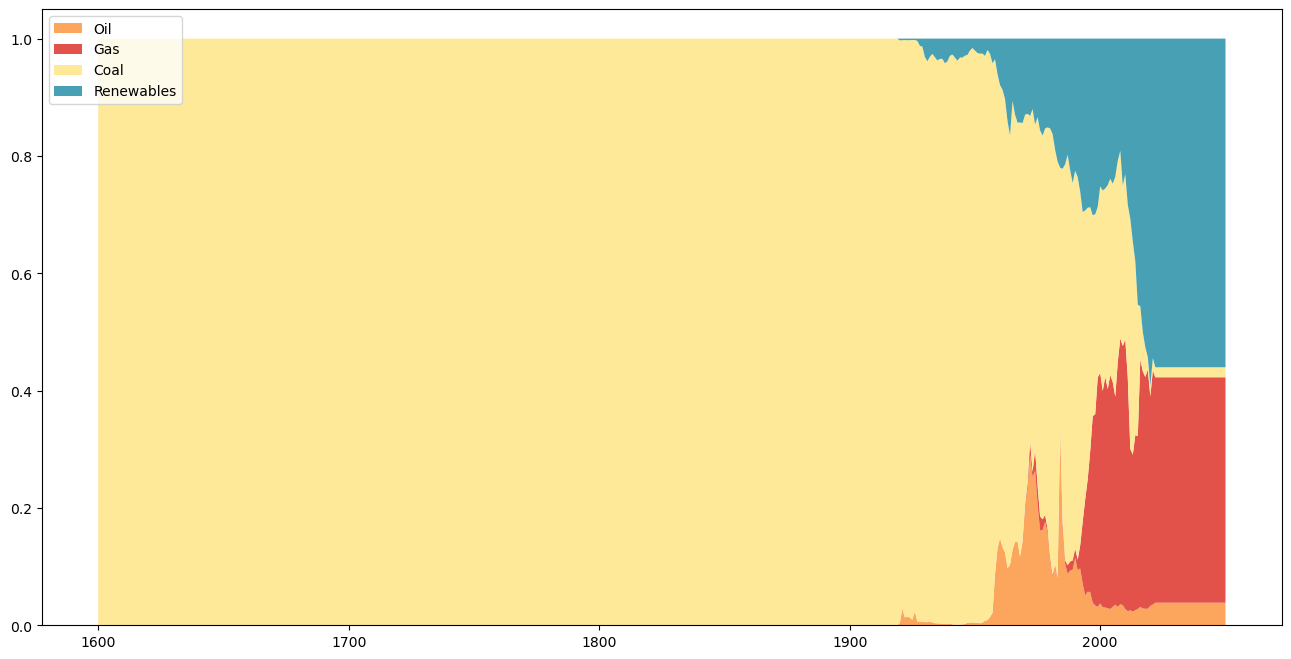

In [38]:
# Source is Our Wolrd in Data (in UK but hypothesis it is the same share in England)
# https://ourworldindata.org/grapher/electricity-mix-uk

file = "Data/GOV UK/electricity-mix-uk.csv"
ELEC_mix = pd.read_csv(file)
ELEC_mix = ELEC_mix.drop(columns=['Entity','Code'])
ELEC_mix = ELEC_mix.set_index('Year')
ELEC_mix.columns = ['Other renewables','Hydropower','Solar','Wind','Nuclear','Imports','Oil','Gas','Coal']
ELEC_mix = ELEC_mix.drop(columns=['Imports'])
display(ELEC_mix)

colors = sns.color_palette("Spectral")[0:6]
colors = [colors[1],colors[0],colors[2],colors[5]]

ELEC_mix_shares = ELEC_mix.copy(deep=True)
for i in ELEC_mix_shares.index:
    total = ELEC_mix.loc[i,:].sum()
    for j in ELEC_mix_shares.columns:
        ELEC_mix_shares.loc[i,j] = ELEC_mix.loc[i,j]/total
shares_before_1920 = [0,0,0,0,0,0,0,1]
for i in np.arange(1600,1920):
    ELEC_mix_shares.loc[i,:] = shares_before_1920
shares_after_2022_bau = ELEC_mix_shares.loc[2022,:]
for i in np.arange(2023,2051):
    ELEC_mix_shares.loc[i,:] = shares_after_2022_bau
ELEC_mix_shares = ELEC_mix_shares.sort_index()
ELEC_mix_shares['Renewables'] = ELEC_mix_shares['Other renewables']+ELEC_mix_shares['Hydropower']+ELEC_mix_shares['Solar']+ELEC_mix_shares['Wind']+ELEC_mix_shares['Nuclear']
ELEC_mix_shares = ELEC_mix_shares.drop(columns=['Other renewables','Hydropower','Solar','Wind','Nuclear'])
display(ELEC_mix_shares)
#display(ELEC_mix_shares.sum(axis=1))

stack_ELEC_mix_shares = [ELEC_mix_shares[k].to_list() for k in ELEC_mix_shares.columns]
lab = [str(k) for k in ELEC_mix_shares.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(ELEC_mix_shares.index,stack_ELEC_mix_shares, labels=lab, colors=colors[:5])
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/electricity-mix-bau.png",dpi=300,bbox_inches="tight")
plt.plot()

In [39]:
NRJ_FEC = pd.DataFrame(index=np.arange(1600,2051),columns = NRJ_final+['Renewables']).astype('float')
#for i in np.arange(1600,1801):
#    for j in NRJ_FEC.columns:
#        if j == 'Wood':
#            NRJ_FEC.loc[i,j] = 1
#        else:
#            NRJ_FEC.loc[i,j] = 0
for j in NRJ_FEC.columns:
    if j == 'Wood':
        NRJ_FEC.loc[1600,j] = 1
    else:
        NRJ_FEC.loc[1600,j] = 0
for j in NRJ_FEC.columns:
    if j == 'Wood':
        NRJ_FEC.loc[1799,j] = 1
    else:
        NRJ_FEC.loc[1799,j] = 0
#NRJ_FEC.loc[1600:1799,:].interpolate(method='linear',inplace=True)
#display(NRJ_FEC)
for j in NRJ_FEC.columns:
    if j == 'Wood':
        NRJ_FEC.loc[1900,j] = 0.7
    elif j == 'Coal':
        NRJ_FEC.loc[1900,j] = 0.3
    else:
        NRJ_FEC.loc[1900,j] = 0
#NRJ_FEC.loc[1799:1900,:].interpolate(method='linear',inplace=True)
for j in NRJ_FEC.columns:
    if j == 'Wood':
        NRJ_FEC.loc[1950,j] = 0.2
    elif j == 'Coal':
        NRJ_FEC.loc[1950,j] = 0.8
    else:
        NRJ_FEC.loc[1950,j] = 0
for i in np.arange(1980,2051):
    for j in NRJ_final:
        NRJ_FEC.loc[i,j] = NRJ_final_shares.loc['Shares',j]
        NRJ_FEC.loc[i,'Renewables'] = 0
for i in np.arange(1600,2051):
    for j in ELEC_mix_shares.columns:
        NRJ_FEC.loc[i,j] += NRJ_FEC.loc[i,'Electricity']*ELEC_mix_shares.loc[i,j]
display(NRJ_FEC.loc[1945:1955,:])
NRJ_FEC.interpolate(method='linear',inplace=True)
NRJ_FEC = NRJ_FEC.drop(columns='Electricity')
for i in NRJ_FEC.index:
    total = NRJ_FEC.loc[i,:].sum()
    for j in NRJ_FEC.columns:
        NRJ_FEC.loc[i,j] = NRJ_FEC.loc[i,j]/total

#display(NRJ_FEC.loc[1600:1610,:])
#display(NRJ_FEC.loc[1795:1805,:])
#display(NRJ_FEC.loc[1945:1955,:])

test = True
for t in NRJ_FEC.sum(axis=1)==[1.0 for i in np.arange(1600,2051)]:
    test = t 
print(test,' => We have 100% totals')

,Gas,Electricity,Oil,Coal,Wood,LPG,Renewables
1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,0.0,0.0,0.0,0.8,0.2,0.0,0.0
1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN


True  => We have 100% totals


In [40]:
NRJ_FEC.to_csv("Model/FEC-energy-mix-bau.csv")

[]

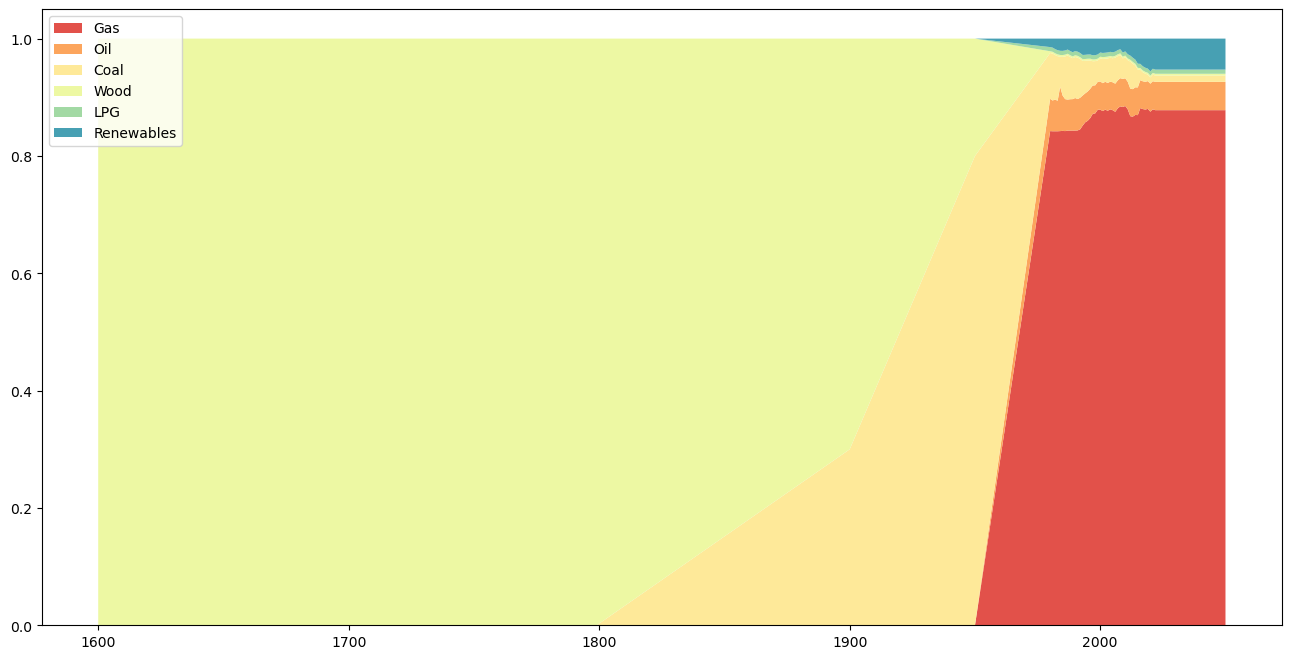

In [41]:
colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC = [NRJ_FEC[k].to_list() for k in NRJ_FEC.columns]
lab = [str(k) for k in NRJ_FEC.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC.index,stack_NRJ_FEC, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources.png",dpi=300,bbox_inches="tight")
plt.plot()

For later: future projections (2021 - 2050)
The UK government's commitment to reducing carbon emissions to net zero by 2050 implies significant changes in how homes are heated:

Reduction in Natural Gas Use: Expected to decrease significantly as bans on new gas boilers in new homes will be enforced starting in 2025, with broader restrictions likely to follow.
Increase in Heat Pumps and Electric Heating: Projected to be the leading technologies replacing gas, with targets of installing 600,000 heat pumps per year by 2028.
Expansion of Renewable Heating: Solar thermal, biomass, and other renewable technologies are expected to play larger roles.
Hydrogen and Bioenergy: Some projections include the potential role of hydrogen (especially blending into the gas network) and increased use of bioenergy as transitional or long-term solutions for decarbonizing heating.

In [43]:
# The average UK annual gas consumption is 16,000 kWh per household

# And other AFUE (Annual Fuel Utilization Efficiency) numbers found on the internet

NRJ_EFF = pd.DataFrame(index=np.arange(1600,2051),columns = NRJ_FEC.columns).astype('float')
NRJ_EFF.index.name = 'Time'
for i in NRJ_EFF.index:
    NRJ_EFF.loc[i,'Gas'] = 0.95 # efficiency
    # TBD GAS 70 BEFORE ??? 
    NRJ_EFF.loc[i,'Oil'] = 0.85 
    NRJ_EFF.loc[i,'Coal'] = 0.70 
    NRJ_EFF.loc[i,'Wood'] = 0.80 
    NRJ_EFF.loc[i,'LPG'] = 0.95 
    NRJ_EFF.loc[i,'Renewables'] = 0.60
display(NRJ_EFF)

,Gas,Oil,Coal,Wood,LPG,Renewables
Time,,,,,,
1600,0.95,0.85,0.7,0.8,0.95,0.6
1601,0.95,0.85,0.7,0.8,0.95,0.6
1602,0.95,0.85,0.7,0.8,0.95,0.6
1603,0.95,0.85,0.7,0.8,0.95,0.6
1604,0.95,0.85,0.7,0.8,0.95,0.6
...,...,...,...,...,...,...
2046,0.95,0.85,0.7,0.8,0.95,0.6
2047,0.95,0.85,0.7,0.8,0.95,0.6
2048,0.95,0.85,0.7,0.8,0.95,0.6


In [44]:
def mean_energy(col,fec,raw):
    mean_table = pd.DataFrame(index=np.arange(1600,2051),columns = [col]).astype('float')
    mean_table.index.name = 'Time'
    for i in mean_table.index:
        mean_table.loc[i,col] = fec.loc[i,'Gas']*raw.loc[i,'Gas'] + fec.loc[i,'Oil']*raw.loc[i,'Oil'] + fec.loc[i,'Coal']*raw.loc[i,'Coal'] + fec.loc[i,'Wood']*raw.loc[i,'Wood'] + fec.loc[i,'LPG']*raw.loc[i,'LPG'] + fec.loc[i,'Renewables']*raw.loc[i,'Renewables']
    return mean_table

NRJ_EFF_MEAN = mean_energy('Efficiency',NRJ_FEC,NRJ_EFF)
display(NRJ_EFF_MEAN)

print('The average efficiency of the UK/England heating energy is of about : ', NRJ_EFF_MEAN['Efficiency'].mean())

,Efficiency
Time,
1600,0.800000
1601,0.800000
1602,0.800000
1603,0.800000
1604,0.800000
...,...
2046,0.923541
2047,0.923541
2048,0.923541


The average efficiency of the UK/England heating energy is of about :  0.8111272467741026


In [45]:
NRJ_AsBuilt_FEC_Time_ktoe = NRJ_AsBuilt_Time_ktoe.copy(deep=True)

def ED_to_FEC(NRJ_FEC_Time,NRJ_ED_Time,NRJ_efficiency_mean=NRJ_EFF_MEAN):
    for k in NRJ_FEC_Time.columns:
        NRJ_FEC_Time[k] = NRJ_ED_Time[k]/NRJ_efficiency_mean['Efficiency']
    return NRJ_FEC_Time

NRJ_AsBuilt_FEC_Time_ktoe = ED_to_FEC(NRJ_AsBuilt_FEC_Time_ktoe,NRJ_AsBuilt_Time_ktoe)

display(NRJ_AsBuilt_Time_ktoe)
display(NRJ_AsBuilt_FEC_Time_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,46969.656992,309.965912,4233.854828,14229.483031,28196.353222
2047,46924.486967,311.305372,4239.364411,14264.543447,28109.273738
2048,46880.388824,312.671335,4245.112482,14300.640412,28021.964595


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,50858.252473,335.627842,4584.373648,15407.535138,30530.715846
2047,50809.342844,337.078195,4590.339367,15445.49819,30436.427092
2048,50761.593836,338.557246,4596.563318,15484.583605,30341.889667


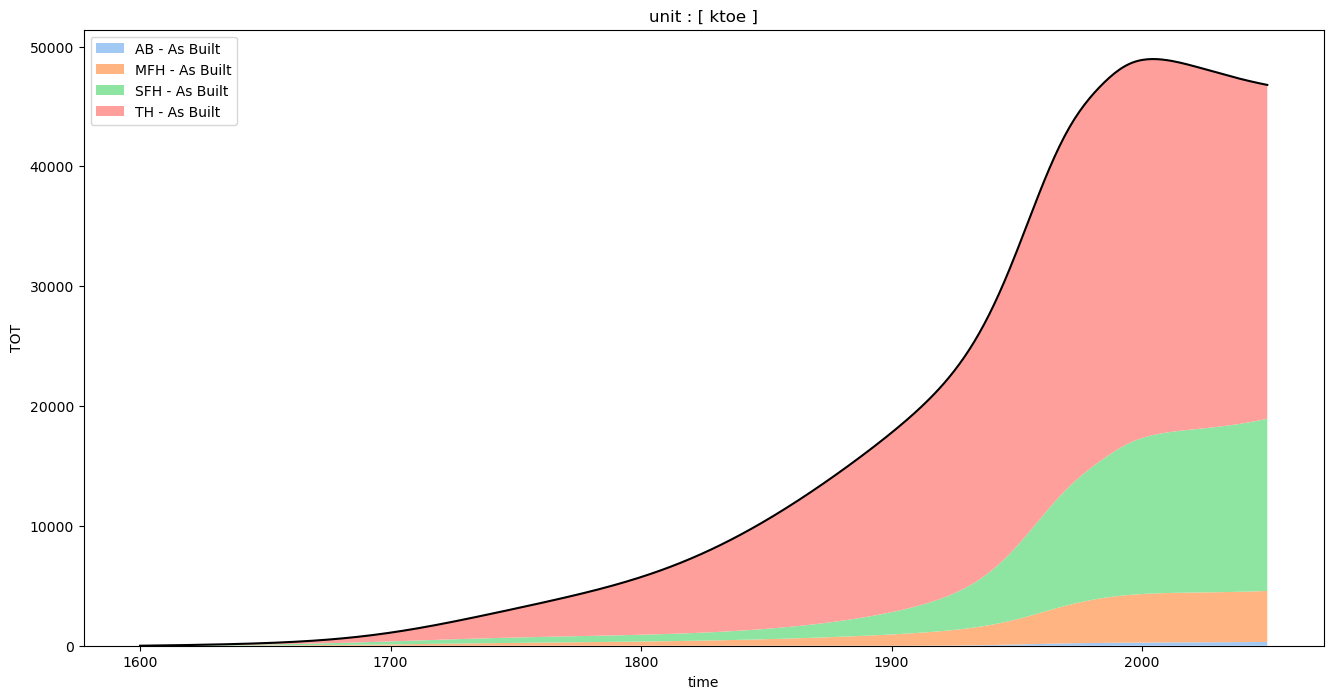

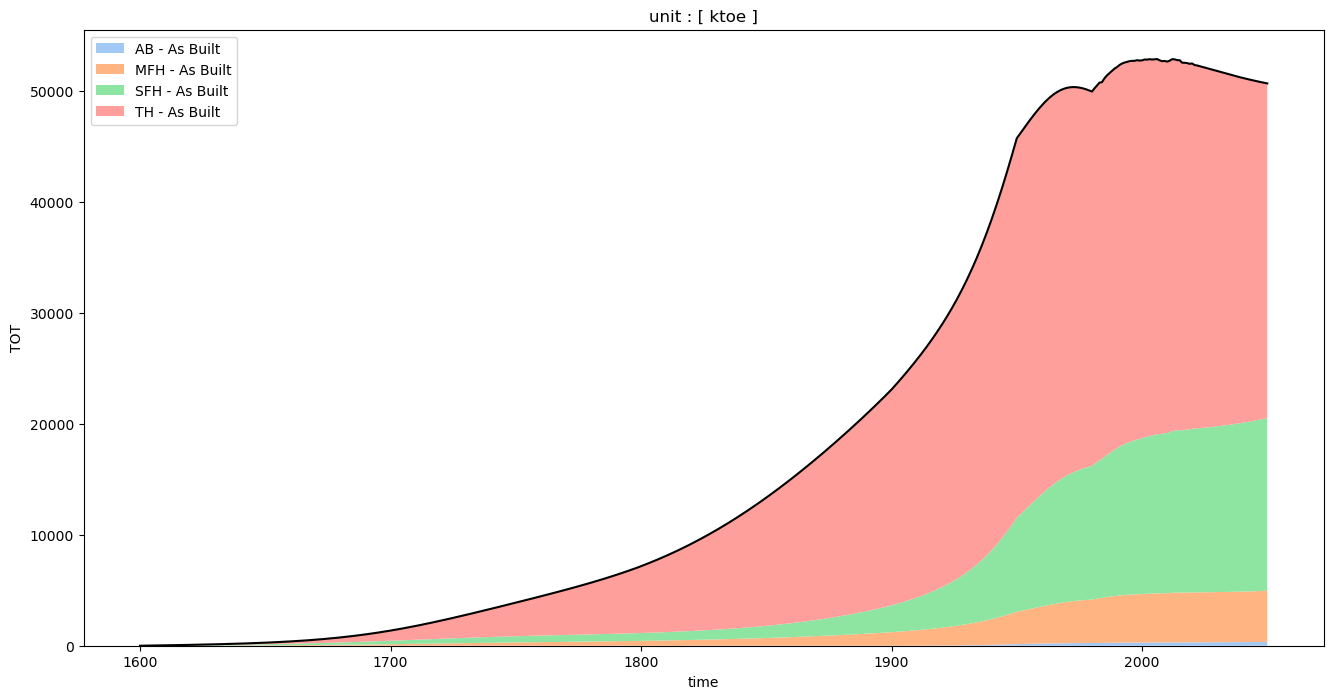

In [46]:
display_NRJ(NRJ_AsBuilt_Time_ktoe,'ktoe',' - As Built')
display_NRJ(NRJ_AsBuilt_FEC_Time_ktoe,'ktoe',' - As Built','Energy/ktoe_per_type_AsBuilt_FEC.png')

,Gas,Oil,Coal,Wood,LPG,Renewables
Time,,,,,,
1600,0.185,0.255,0.4075,0.025,0.22,0.03
1601,0.185,0.255,0.4075,0.025,0.22,0.03
1602,0.185,0.255,0.4075,0.025,0.22,0.03
1603,0.185,0.255,0.4075,0.025,0.22,0.03
1604,0.185,0.255,0.4075,0.025,0.22,0.03
...,...,...,...,...,...,...
2046,0.185,0.255,0.4075,0.025,0.22,0.03
2047,0.185,0.255,0.4075,0.025,0.22,0.03
2048,0.185,0.255,0.4075,0.025,0.22,0.03


,Emissions
Time,
1600,0.025000
1601,0.025000
1602,0.025000
1603,0.025000
1604,0.025000
...,...
2046,0.182339
2047,0.182339
2048,0.182339


The average CO2e emissions of the UK/England heating energy is of about :  0.10299150178266056  kCO2e/kWh
The average CO2e emissions of the UK/England heating energy is of about :  102.99150178266056  kCO2e/MWh
The average CO2e emissions of the UK/England heating energy is of about :  1.1977911657323423  tCO2e/toe
The average CO2e emissions of the UK/England heating energy is of about :  1197.7911657323423  tCO2e/ktoe


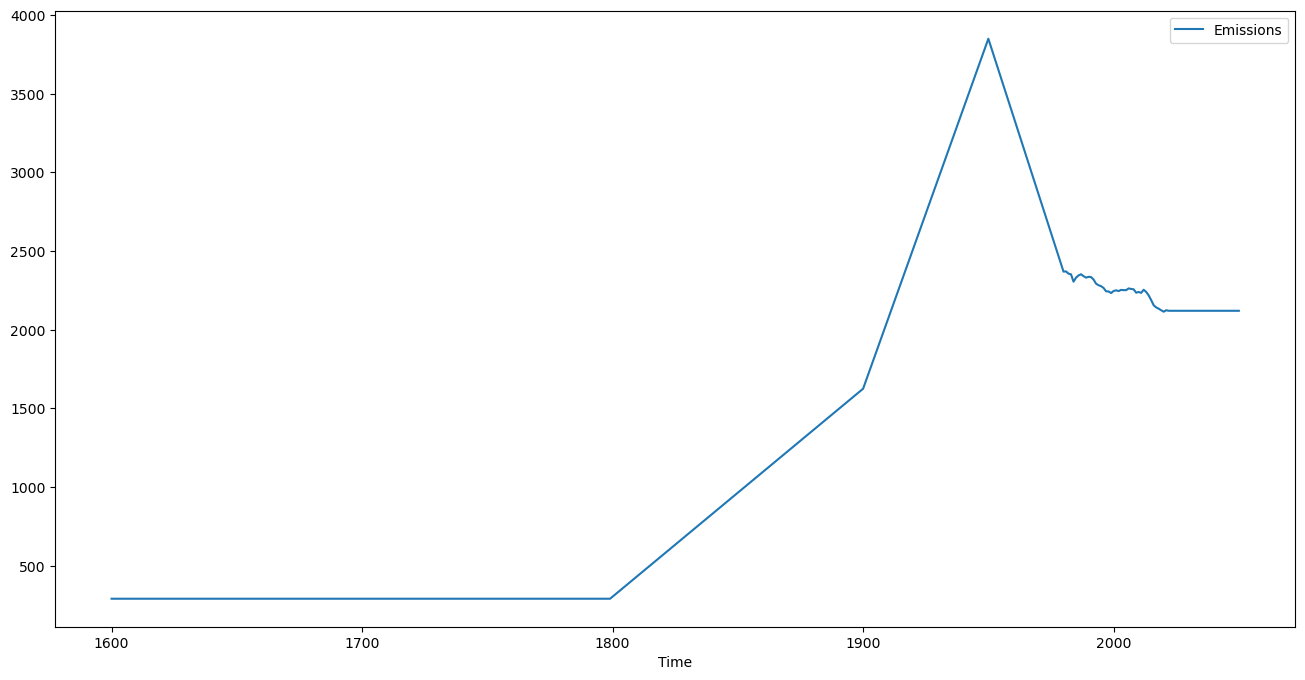

In [47]:
# Source : https://www.carbonindependent.org/15.html
# The average UK annual gas consumption is 16,000 kWh per household

# Source : https://www.euronuclear.org/glossary/fuel-comparison/#:~:text=8%20kWh%20of%20heat%20can,1%20kg%20of%20uranium%2D235.

# Hypothesis: same emissions throught time 

NRJ_CO2 = pd.DataFrame(index=np.arange(1600,2051),columns = NRJ_FEC.columns).astype('float')
NRJ_CO2.index.name = 'Time'
for i in NRJ_CO2.index:
    NRJ_CO2.loc[i,'Gas'] = 0.185 # kgCO2/kWh
    NRJ_CO2.loc[i,'Oil'] = 0.255 # kgCO2/kWh
    # 3.26 kg CO2 per kg of coal & 8 kWh of heat can be generated from 1 kg of coal
    NRJ_CO2.loc[i,'Coal'] = 3.26/8 # kgCO2/kWh
    # 0.10 kg CO2 per kg of wood & 4 kWh of heat can be generated from 1 kg of wood
    NRJ_CO2.loc[i,'Wood'] = 0.10/4 # kgCO2/kWh
    NRJ_CO2.loc[i,'LPG'] = 0.220 # kgCO2/kWh
    NRJ_CO2.loc[i,'Renewables'] = 0.030 # kgCO2/kWh

display(NRJ_CO2)

NRJ_CO2_MEAN = mean_energy('Emissions',NRJ_FEC,NRJ_CO2) # EMISSIONS NOT EFFICIENCY 
display(NRJ_CO2_MEAN)
print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' kCO2e/kWh')

NRJ_CO2_MEAN = NRJ_CO2_MEAN*1000
#display(NRJ_CO2_MEAN)
print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' kCO2e/MWh')

NRJ_CO2_MEAN = NRJ_CO2_MEAN*11.63/1000
#display(NRJ_CO2_MEAN)
print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' tCO2e/toe')

NRJ_CO2_MEAN = NRJ_CO2_MEAN*1000
#display(NRJ_CO2_MEAN)
print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' tCO2e/ktoe')

ax = plt.figure(figsize=(16,8))
sns.lineplot(data=NRJ_CO2_MEAN)
plt.show()

In [48]:
NRJ_AsBuilt_CO2_Time = NRJ_AsBuilt_FEC_Time_ktoe.copy(deep=True)

def FEC_to_CO2(NRJ_CO2_Time,NRJ_FEC_Time,NRJ_CO2_mean=NRJ_CO2_MEAN):
    for k in NRJ_CO2_Time.columns:
        NRJ_CO2_Time[k] = NRJ_FEC_Time[k]*NRJ_CO2_mean['Emissions']/1000 # ktCO2e/ktoe 
    return NRJ_CO2_Time

NRJ_AsBuilt_CO2_Time_ktoe = FEC_to_CO2(NRJ_AsBuilt_CO2_Time,NRJ_AsBuilt_FEC_Time_ktoe)

display(NRJ_AsBuilt_FEC_Time_ktoe)
display(NRJ_AsBuilt_CO2_Time)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,50858.252473,335.627842,4584.373648,15407.535138,30530.715846
2047,50809.342844,337.078195,4590.339367,15445.49819,30436.427092
2048,50761.593836,338.557246,4596.563318,15484.583605,30341.889667


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,0.941876,0.0,0.162822,0.442641,0.336413
1602,1.899382,0.0,0.327147,0.888632,0.683603
1603,2.875263,0.0,0.493411,1.33913,1.042722
1604,3.86944,0.0,0.661557,1.793954,1.413929
...,...,...,...,...,...
2046,107850.255147,711.734017,9721.644837,32673.293223,64743.583069
2047,107746.53715,714.809645,9734.29577,32753.797852,64543.633884
2048,107645.280375,717.946126,9747.494311,32836.682572,64343.157366


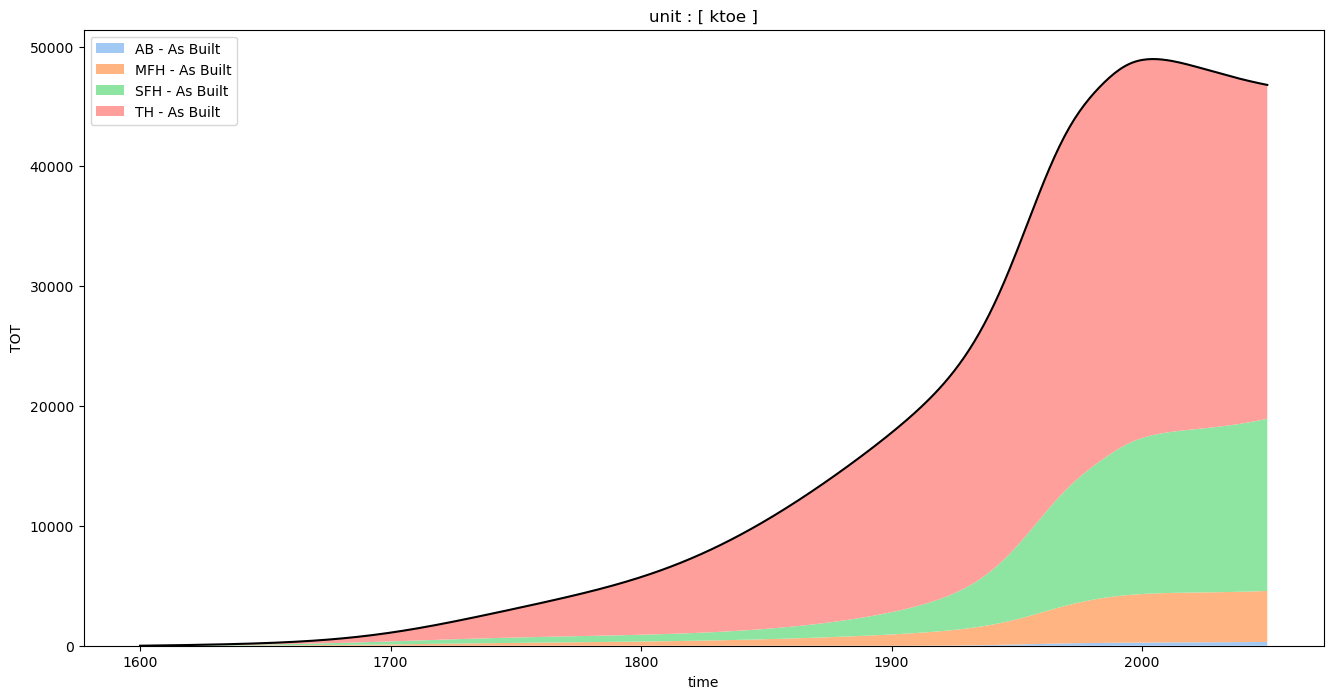

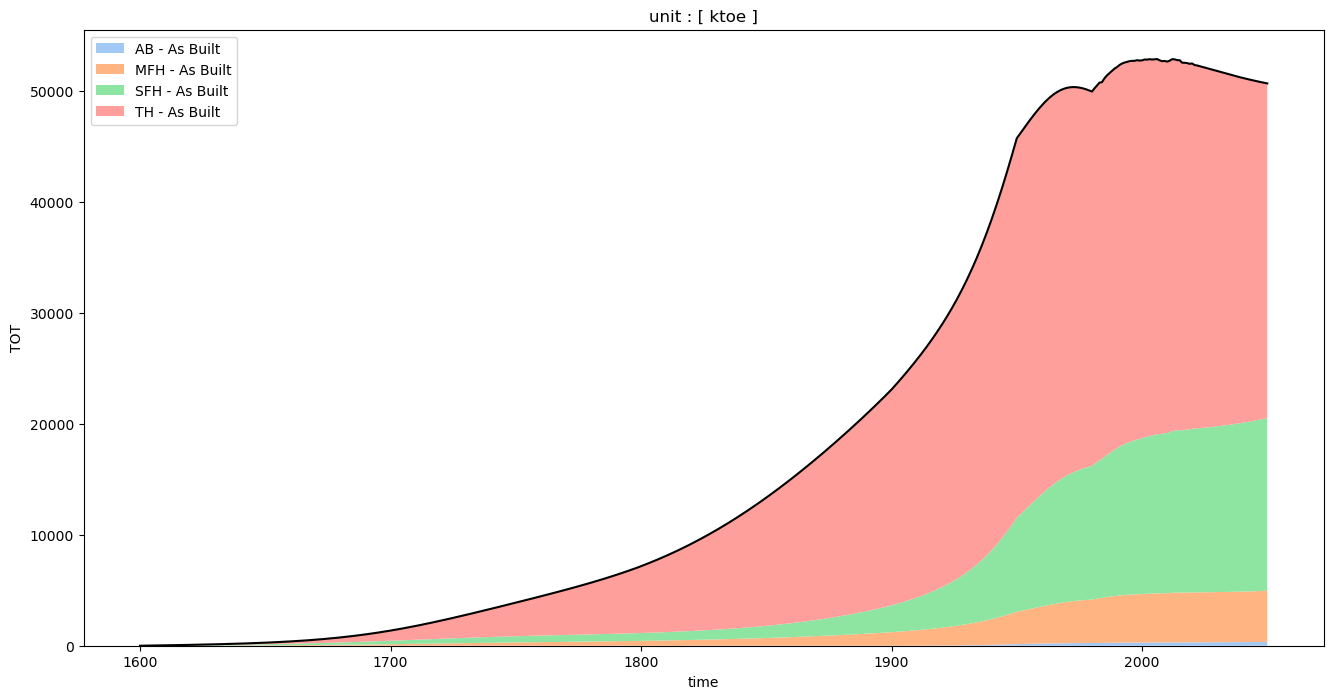

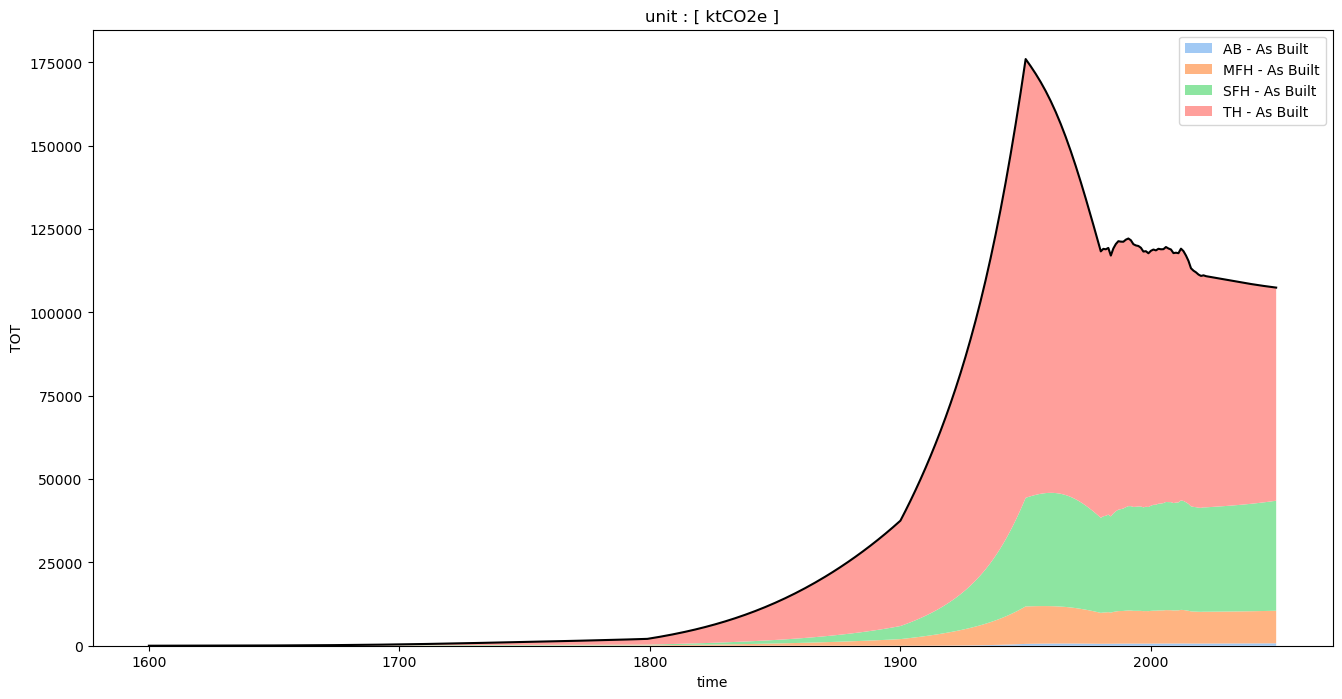

In [49]:
display_NRJ(NRJ_AsBuilt_Time_ktoe,'ktoe',' - As Built')
display_NRJ(NRJ_AsBuilt_FEC_Time_ktoe,'ktoe',' - As Built')
display_NRJ(NRJ_AsBuilt_CO2_Time_ktoe,'ktCO2e',' - As Built','Energy/co2_per_type_AsBuilt_FEC.png')

# Integrate a certain renovation

Sources to look at eventually: 

* European Environment Agency: https://www.eea.europa.eu/en/analysis/indicators/greenhouse-gas-emissions-from-energy?activeAccordion= 
* 

0.0
0.0


,TOT_Rfb,incl. Std_Rfb,incl. Amb_Rfb
1600,0.00,0.000,0.000
1601,0.00,0.000,0.000
1602,0.00,0.000,0.000
1603,0.00,0.000,0.000
1604,0.00,0.000,0.000
...,...,...,...
2046,0.03,0.024,0.006
2047,0.03,0.024,0.006
2048,0.03,0.024,0.006
2049,0.03,0.024,0.006


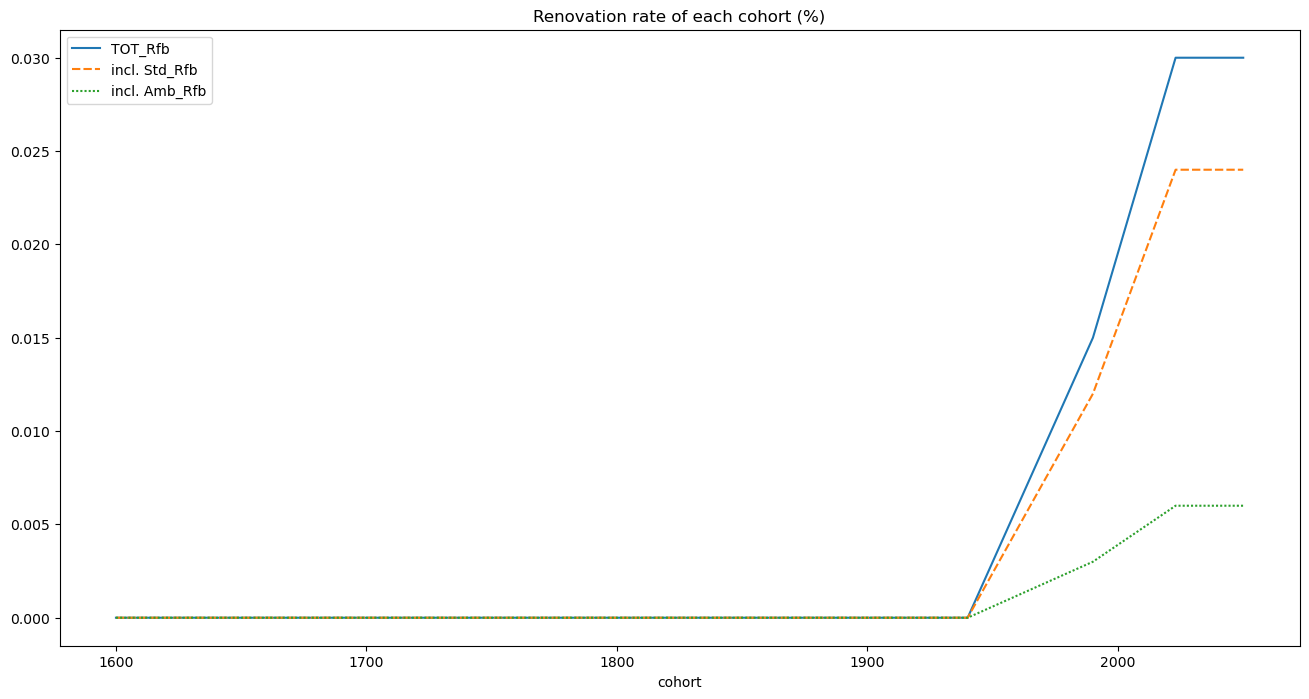

,TOT_Rfb,incl. Std_Rfb,incl. Amb_Rfb
1600,NaN,NaN,NaN
1601,0.000000,0.000000,0.000000
1602,0.000000,0.000000,0.000000
1603,0.000000,0.000000,0.000000
1604,0.000000,0.000000,0.000000
...,...,...,...
2046,803454.057646,642763.246117,160690.811529
2047,806824.784502,645459.827601,161364.956900
2048,810223.374474,648178.699580,162044.674895
2049,813649.793778,650919.835023,162729.958756


[]

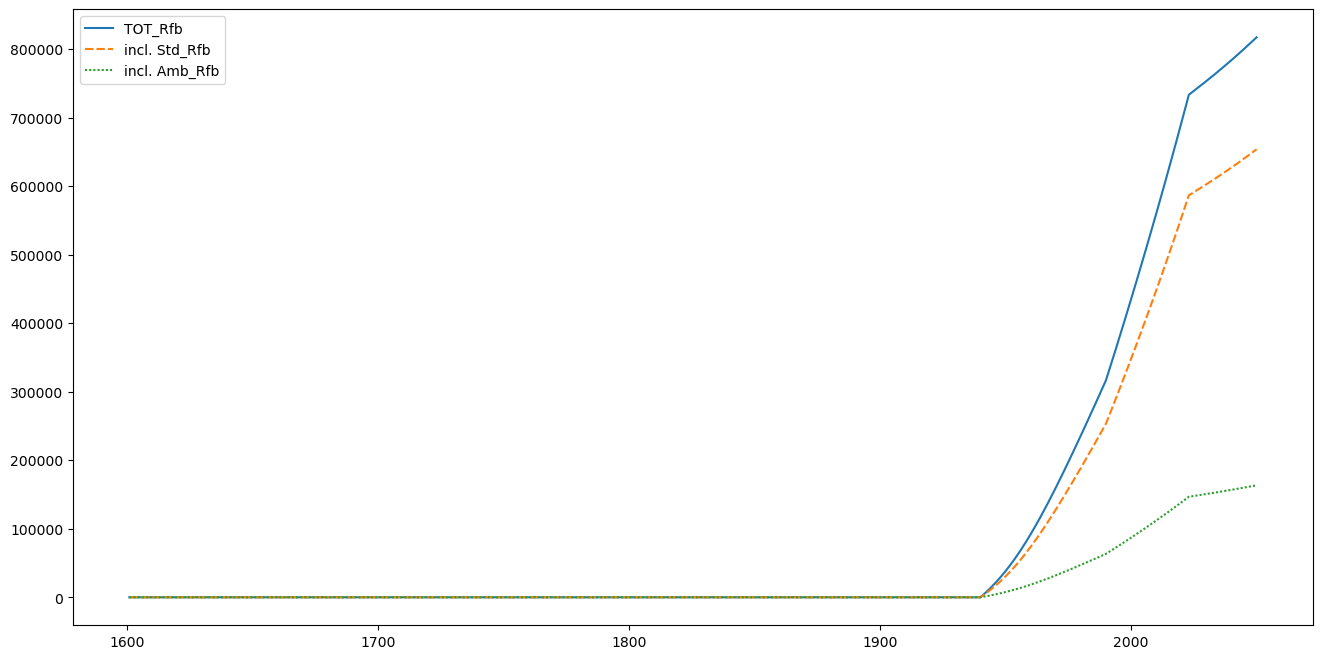

In [103]:
# Source: EPISCOPE 
# We start with taking an average of 3% renovation rate

"""
We could also make the assumptions that:
- Renovation begins only at a certain period (?)
- Renovated dwellings will not be renovated a second time OR only a certain amount of time
- Renovation happen only a certain amount of time
- The older buildings, the higher the probability to get renovated
⇒ Choose the curve for renovation probability and the mechanism behind the renovation state transitions
"""

reno_col = ['TOT_Rfb','incl. Std_Rfb','incl. Amb_Rfb']
renovation_share_time = pd.DataFrame(index=np.arange(1600,2051),columns=reno_col)

# Total number (share) of renovation in time 

start_year_reno = 1940
middle_year_reno = 1990
reno_rate_2023 = 3/100
reno_rate_2050 = 3/100

# In which Standard and Ambitious Refurbishment

share_Amb_Rfb = 0.2
share_Std_Rfb = 1-share_Amb_Rfb

def fill_tot_rfb_rate(renovation,start_year,mid_year,rate_2023,rate_2050,share_Amb):
    share_Std = 1-share_Amb
    # TOTAL RFB 
    for j in renovation.columns:
        renovation[j] = renovation[j].astype('float')
    renovation.loc[1600,'TOT_Rfb'] = 0
    renovation.loc[start_year,'TOT_Rfb'] = 0
    renovation.loc[mid_year,'TOT_Rfb'] = rate_2023/2
    renovation.loc[2023,'TOT_Rfb'] = rate_2023
    renovation.loc[2050,'TOT_Rfb'] = rate_2050
    renovation.interpolate(method='linear',inplace=True) 
    # Standard and ambitious refurbishment
    renovation.loc[1600,'incl. Std_Rfb'] = share_Std*renovation.loc[1600,'TOT_Rfb']
    renovation.loc[1600,'incl. Amb_Rfb'] = share_Amb*renovation.loc[1600,'TOT_Rfb']
    renovation.loc[start_year,'incl. Std_Rfb'] = share_Std*renovation.loc[start_year,'TOT_Rfb']
    renovation.loc[start_year,'incl. Amb_Rfb'] = share_Amb*renovation.loc[start_year,'TOT_Rfb']
    renovation.loc[mid_year,'incl. Std_Rfb'] = share_Std*renovation.loc[mid_year,'TOT_Rfb']
    renovation.loc[mid_year,'incl. Amb_Rfb'] = share_Amb*renovation.loc[mid_year,'TOT_Rfb']
    renovation.loc[2023,'incl. Std_Rfb'] = share_Std*renovation.loc[2023,'TOT_Rfb']
    renovation.loc[2023,'incl. Amb_Rfb'] = share_Amb*renovation.loc[2023,'TOT_Rfb']
    renovation.loc[2050,'incl. Std_Rfb'] = share_Std*renovation.loc[2050,'TOT_Rfb']
    renovation.loc[2050,'incl. Amb_Rfb'] = share_Amb*renovation.loc[2050,'TOT_Rfb']
    renovation.interpolate(method='linear',inplace=True) 
    print(renovation.loc[1601,'TOT_Rfb'])
    
    print(renovation.loc[1601,'TOT_Rfb'])
    return renovation

renovation_share_time = fill_tot_rfb_rate(renovation_share_time,start_year_reno,middle_year_reno,reno_rate_2023,reno_rate_2050,share_Amb_Rfb)

display(renovation_share_time)

renovation_share_time.to_csv("Model/Renovation.csv")

ax = plt.figure(figsize=(16,8))
sns.lineplot(data=renovation_share_time)
plt.title('Renovation rate of each cohort (%)')
plt.xlabel('cohort')
plt.savefig('Output/Renovation/Renovation-rate.png',dpi=300,bbox_inches='tight')
plt.show()

def renovation(renovation_share,dystomod):
    renovation_time = renovation_share.copy(deep=True)
    for i in renovation_time.index:
        for j in renovation_time.columns:
            renovation_time.loc[i,j] = renovation_share.loc[i,j]*dystomod.loc[i,'Stock']
    return renovation_time

renovation_time = renovation(renovation_share_time,DSM)

display(renovation_time)
ax = plt.figure(figsize=(16,8))
sns.lineplot(data=renovation_time)
plt.plot()

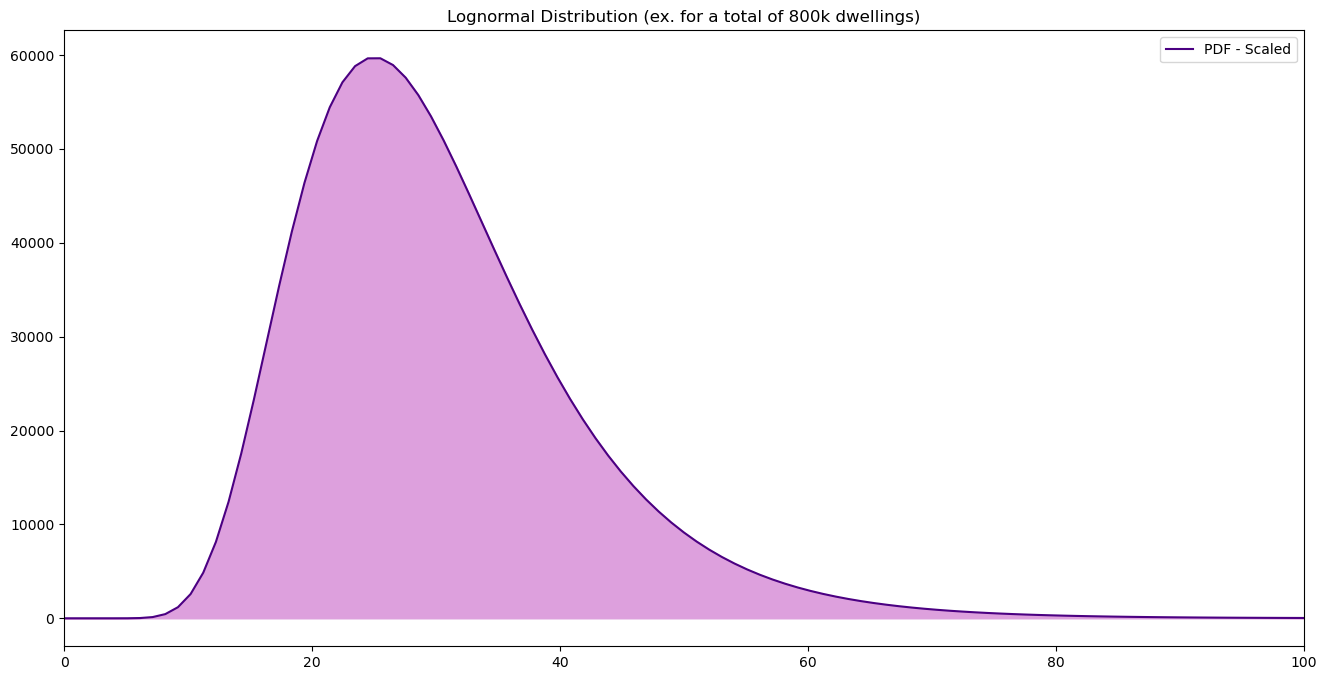

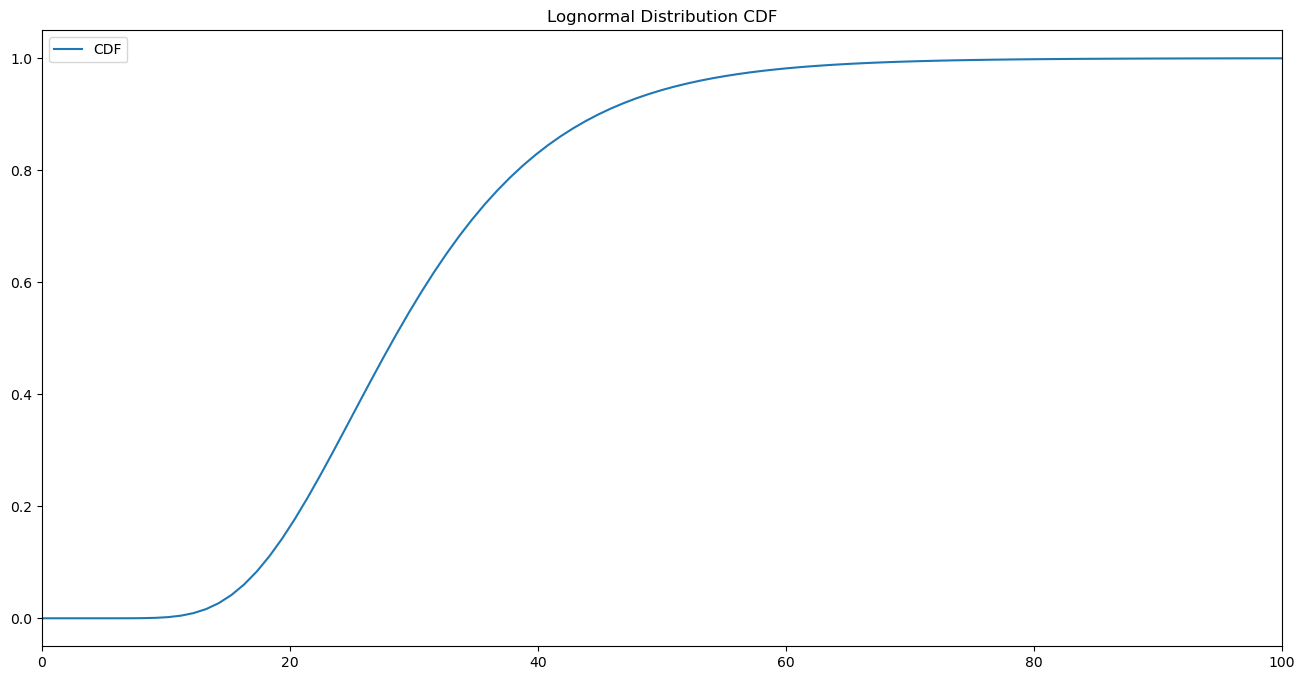

In [104]:
mode = 25
begin_increase = 22
end_decrease = 30
total = 800000

def Std_Rfb_distribution(number,mode=mode,begin_increase=begin_increase,end_decrease=end_decrease):
    # Use mode to estimate sigma considering the increase and decrease intervals
    # Since mode = exp(mu - sigma^2), solve for mu and sigma
    sigma = np.sqrt(np.log(mode / begin_increase))
    mu = np.log(mode) + sigma**2
    # Create a lognormal distribution
    dist = stats.lognorm(s=sigma, scale=np.exp(mu))
    # Generate values
    x = np.linspace(0, 101, 100)
    pdf_values = dist.pdf(x)
    cdf_values = dist.cdf(x)
    # Scale PDF to match the total cumulative distribution
    pdf_scaled = pdf_values * (number / dist.cdf(end_decrease))
    return x,pdf_values,pdf_scaled,cdf_values

x,pdf_values,pdf_scaled,cdf_values = Std_Rfb_distribution(total)

# Visualization
ax = plt.figure(figsize=(16, 8))
plt.plot(x, pdf_scaled, label='PDF - Scaled',color='indigo')
plt.fill_between(x, pdf_scaled, color='plum')
plt.title('Lognormal Distribution (ex. for a total of 800k dwellings)')
plt.xlim(0, 100)
plt.legend()
fig = ax.get_figure()
fig.savefig("Output/Renovation/Renovation_distribution.png",dpi=300,bbox_inches="tight")
plt.show()

ax = plt.figure(figsize=(16, 8))
plt.plot(x, cdf_values, label='CDF')
plt.title('Lognormal Distribution CDF')
plt.xlim(0, 100)
plt.legend()
plt.show()

In [52]:
def refurbishment_on_cohorts(cohort,renovation_share,dystomod):
    cohort_AsBuilt = cohort.copy(deep=True)
    cohort_StdRfb = cohort.copy(deep=True)
    for col in cohort_StdRfb.columns:
        cohort_StdRfb[col].values[:] = 0
    cohort_AmbRfb = cohort.copy(deep=True)
    for col in cohort_AmbRfb.columns:
        cohort_AmbRfb[col].values[:] = 0
    renovation_numbers = renovation(renovation_share,dystomod)
    for c in cohort.columns: 
        #print('NEW COHORT')
        #share_Std_Rfb = renovation_share.loc[c,'incl. Std_Rfb']
        #share_Amb_Rfb = renovation_share.loc[c,'incl. Amb_Rfb']
        number_Std_Rfb = renovation_numbers.loc[c,'incl. Std_Rfb']
        number_Amb_Rfb = renovation_numbers.loc[c,'incl. Amb_Rfb']
        #print('Std and Amb rfb shares : ',share_Std_Rfb,share_Amb_Rfb)
        #print('Std and Amb rfb numbers : ',number_Std_Rfb,number_Amb_Rfb)
        x_Std,pdf_values_Std,pdf_scaled_Std,cdf_values_Std = Std_Rfb_distribution(number_Std_Rfb)
        x_Amb,pdf_values_Amb,pdf_scaled_Amb,cdf_values_Amb = Std_Rfb_distribution(number_Amb_Rfb)
        cumulated_Std = 0 
        cumulated_Amb = 0 
        bout = c
        for n in np.arange(1,len(pdf_scaled_Std)):
            bout = c+n
            if bout < 2051:
                new_Std = pdf_scaled_Std[n]
                cumulated_Std += new_Std
                new_Amb = pdf_scaled_Amb[n]
                cumulated_Amb += new_Amb
                cohort_AsBuilt.loc[c+n,c] = cohort.loc[c+n,c] - (cumulated_Std+cumulated_Amb)
                cohort_StdRfb.loc[c+n,c] = cumulated_Std
                cohort_AmbRfb.loc[c+n,c] = cumulated_Amb
        while bout < 2051:
            cohort_AsBuilt.loc[bout,c] = cohort.loc[bout,c] - (cumulated_Std+cumulated_Amb)
            cohort_StdRfb.loc[bout,c] = cumulated_Std
            cohort_AmbRfb.loc[bout,c] = cumulated_Amb
            bout += 1
    return cohort_AsBuilt,cohort_StdRfb,cohort_AmbRfb

cohort_AsBuilt_AB,cohort_StdRfb_AB,cohort_AmbRfb_AB = refurbishment_on_cohorts(cohort_AB,renovation_share_time,DSM_AB)

#display(cohort_AB)
#display(cohort_AsBuilt_AB)
#display(cohort_StdRfb_AB)
#display(cohort_AmbRfb_AB)

cohort_AB_state = [cohort_AsBuilt_AB,cohort_StdRfb_AB,cohort_AmbRfb_AB]

cohort_AsBuilt_MFH,cohort_StdRfb_MFH,cohort_AmbRfb_MFH = refurbishment_on_cohorts(cohort_MFH,renovation_share_time,DSM_MFH)

#display(cohort_MFH)
#display(cohort_AsBuilt_MFH)
#display(cohort_StdRfb_MFH)
#display(cohort_AmbRfb_MFH)

cohort_MFH_state = [cohort_AsBuilt_MFH,cohort_StdRfb_MFH,cohort_AmbRfb_MFH]

cohort_AsBuilt_SFH,cohort_StdRfb_SFH,cohort_AmbRfb_SFH = refurbishment_on_cohorts(cohort_SFH,renovation_share_time,DSM_SFH)

#display(cohort_SFH)
#display(cohort_AsBuilt_SFH)
#display(cohort_StdRfb_SFH)
#display(cohort_AmbRfb_SFH)

cohort_SFH_state = [cohort_AsBuilt_SFH,cohort_StdRfb_SFH,cohort_AmbRfb_SFH]

cohort_AsBuilt_TH,cohort_StdRfb_TH,cohort_AmbRfb_TH = refurbishment_on_cohorts(cohort_TH,renovation_share_time,DSM_TH)

#display(cohort_TH)
#display(cohort_AsBuilt_TH)
#display(cohort_StdRfb_TH)
#display(cohort_AmbRfb_TH)

cohort_TH_state = [cohort_AsBuilt_TH,cohort_StdRfb_TH,cohort_AmbRfb_TH]

cohort_all_states = [cohort_AB_state,cohort_MFH_state,cohort_SFH_state,cohort_TH_state]

In [53]:
display(cohort_AB)
display(cohort_AsBuilt_AB+cohort_StdRfb_AB+cohort_AmbRfb_AB)
display(((cohort_StdRfb_AB+cohort_AmbRfb_AB)/cohort_AB).loc[2020:2030,1995:2005])

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Time ↓ \ Cohort →,,,,,,,,,,,,,,,,,,,,,
1600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,0,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,0,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Time ↓ \ Cohort →,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,NaN,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,NaN,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,NaN,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,NaN,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,NaN,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,NaN,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000


,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
Time ↓ \ Cohort →,,,,,,,,,,,
2020,0.687442,0.636558,0.580345,0.519954,0.456790,0.392477,0.328793,0.267573,0.210597,0.159444,0.115359
2021,0.761992,0.714407,0.660562,0.601388,0.538086,0.472116,0.405152,0.339016,0.275585,0.216668,0.163871
2022,0.835414,0.791881,0.741346,0.684513,0.622360,0.556141,0.487363,0.417750,0.349168,0.283531,0.222684
2023,0.907063,0.868183,0.821742,0.768226,0.708385,0.643242,0.574101,0.502518,0.430259,0.359235,0.291403
2024,0.976420,0.942643,0.900921,0.851537,0.795017,0.732153,0.664016,0.591953,0.517565,0.442664,0.369208
2025,1.043083,1.014720,0.978188,0.933587,0.881233,0.821692,0.755798,0.684663,0.609678,0.532487,0.454954
2026,1.106759,1.083998,1.052984,1.013656,0.966145,0.910801,0.848229,0.779299,0.705164,0.627256,0.547271
2027,1.167252,1.150172,1.124874,1.091164,1.049006,0.998562,0.940215,0.874604,0.802634,0.725496,0.644671
2028,1.224450,1.213038,1.193543,1.165661,1.129217,1.084204,1.030810,0.969452,0.900793,0.825775,0.745638


,Renovation
DSM,
1600,NaN
1601,0.0
1602,0.0
1603,0.0
1604,0.0
...,...
2046,1.329272
2047,1.365503
2048,1.401987


0.5523273880805484


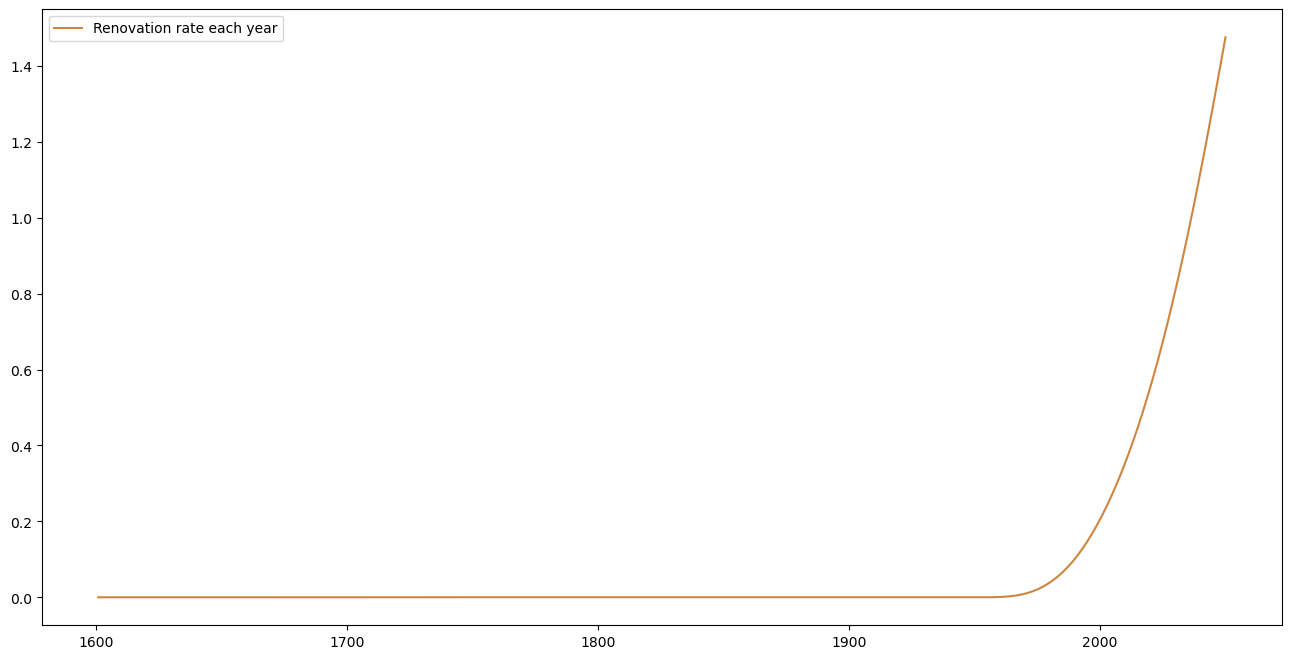

,Renovation
DSM,
1600,0
1601,0.0
1602,0.0
1603,0.0
1604,0.0
...,...
2046,33.995008
2047,35.360511
2048,36.762498


9.930866516054394


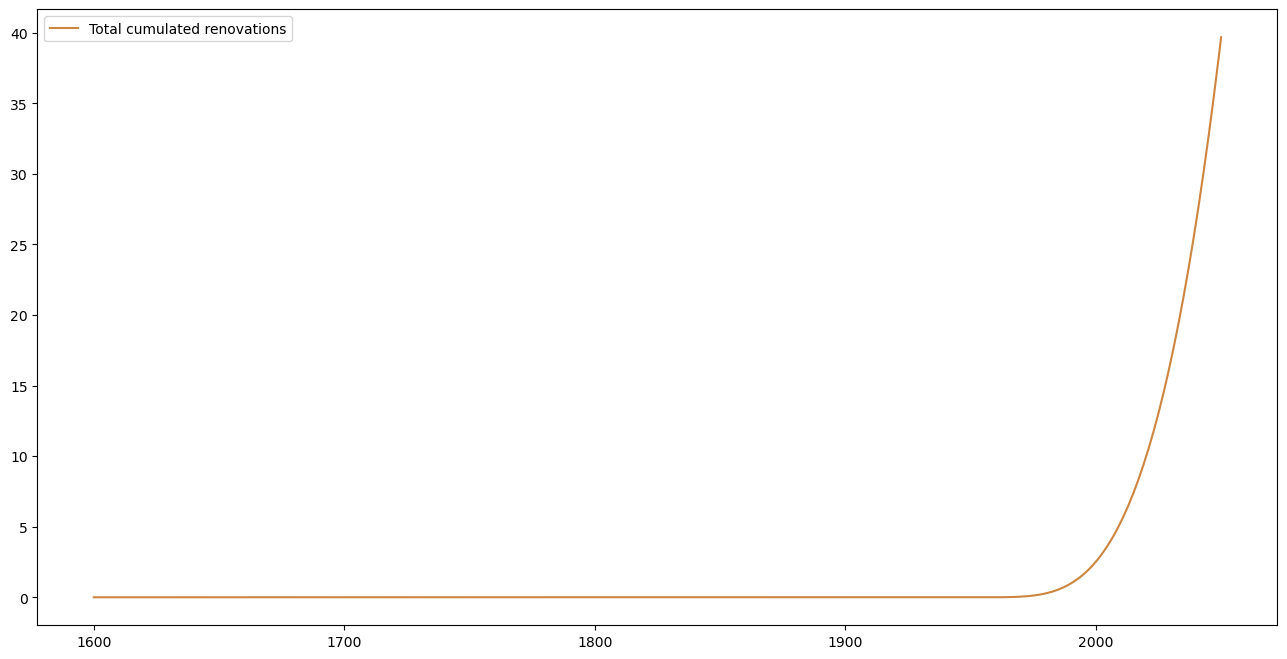

In [54]:
renovation_rate_in_time = pd.DataFrame(index=DSM.index,columns=['Renovation'])
for i in renovation_rate_in_time.index:
    nb_ref = 0 
    for k in np.arange(4):
        for s in np.arange(1,3): # Std_Rfb and Amb_Rfb
            nb_ref += cohort_all_states[k][s].loc[i,:].sum()
            renovation_rate_in_time.loc[i,'Renovation'] = nb_ref/DSM.loc[i,'Stock']

display(renovation_rate_in_time)

print(renovation_rate_in_time.loc[2020,'Renovation'])

ax = plt.figure(figsize=(16,8))
plt.plot(renovation_rate_in_time.index, renovation_rate_in_time['Renovation'], label='Renovation rate each year',color='peru')
plt.legend()
plt.show()

renovation_cumulated_in_time = pd.DataFrame(index=DSM.index,columns=['Renovation'])
renovation_cumulated_in_time.loc[1600,'Renovation'] = 0
for i in renovation_cumulated_in_time.index[1:]:
    renovation_cumulated_in_time.loc[i,'Renovation'] = renovation_cumulated_in_time.loc[i-1,'Renovation'] + renovation_rate_in_time.loc[i,'Renovation']

display(renovation_cumulated_in_time)

print(renovation_cumulated_in_time.loc[2020,'Renovation'])

ax = plt.figure(figsize=(16,8))
plt.plot(renovation_cumulated_in_time.index, renovation_cumulated_in_time['Renovation'], label='Total cumulated renovations',color='peru')
plt.legend()
plt.show()

In [55]:
display(NRJ_AsBuilt_Dwe)
display(NRJ_StdRfb_Dwe)
display(NRJ_AmbRfb_Dwe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,32.000141,26.229481,16.560984,49.799042,33.935441
1601,31.994503,26.223842,16.553119,49.797944,33.928380
1602,31.988979,26.218318,16.545413,49.796869,33.921461
1603,31.983569,26.212907,16.537865,49.795816,33.914685
1604,31.978273,26.207610,16.530477,49.794785,33.908052
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,10.520915,4.457547,6.581151,20.874597,13.000856
1601,10.519062,4.456589,6.578025,20.874137,12.998151
1602,10.517246,4.455650,6.574963,20.873686,12.995501
1603,10.515467,4.454730,6.571964,20.873244,12.992905
1604,10.513726,4.453830,6.569028,20.872812,12.990364
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,8.387121,3.640378,5.001003,16.931855,10.427298
1601,8.385643,3.639596,4.998628,16.931482,10.425128
1602,8.384195,3.638829,4.996301,16.931116,10.423003
1603,8.382777,3.638078,4.994022,16.930758,10.420921
1604,8.381389,3.637343,4.991791,16.930407,10.418882
...,...,...,...,...,...
2046,5.244059,2.716706,3.224506,9.895471,6.287985
2047,5.237024,2.710334,3.221102,9.895642,6.273146
2048,5.230577,2.704341,3.218040,9.895823,6.259656


In [56]:
NRJ_all_dwe = [NRJ_AsBuilt_Dwe,NRJ_StdRfb_Dwe,NRJ_AmbRfb_Dwe]

for t in np.arange(4):
    k = TYP[1+t]
    cohort_ED = cohort_ED_all[t]
    cohort_ED = fill_cohort_ED_to_zeros(cohort_ED)
    cohort_k = cohort_all_states[t]
    for s in np.arange(3):
        cohort_s = cohort_k[s]
        NRJ_s = NRJ_all_dwe[s]
        cohort_ED = fill_cohort_ED(k,cohort_s,NRJ_s,cohort_ED)
    cohort_ED_all[t] = cohort_ED

cohort_ED_AB = cohort_ED_all[0]
cohort_ED_MFH = cohort_ED_all[1]
cohort_ED_SFH = cohort_ED_all[2]
cohort_ED_TH = cohort_ED_all[3]

In [57]:
print('cohort_ED_SFH before in 100% AsBuilt was : 1505157')
display(cohort_ED_SFH)

cohort_ED_SFH before in 100% AsBuilt was : 1505157


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,NaN,14164.520813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,NaN,14077.487139,14358.751362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,NaN,14033.828756,14270.524241,14547.810999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,NaN,13990.079469,14226.267194,14458.422205,14731.747587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,5505.984496,5581.696466,5655.409667,5727.142832,5796.914666,5864.743841,5930.649005,5994.648772,6056.761734,...,930059.743875,945197.876077,960610.50728,976291.045514,992233.667858,1011537.510217,0.0,0.0,0.0,0.0
2047,NaN,5505.781431,5581.485137,5655.18987,5726.91436,5796.677309,5864.497388,5930.393241,5994.38348,6056.486693,...,927115.673562,942220.99964,957600.457286,973247.539868,989156.462602,1005322.133985,1024885.313592,0.0,0.0,0.0
2048,NaN,5505.583644,5581.279287,5654.975758,5726.691784,5796.446063,5864.257265,5930.144029,5994.124968,6056.218664,...,924165.949548,939238.446016,954584.520572,970197.892096,986072.850096,1002204.337589,1018587.921994,1038406.452511,0.0,0.0


In [58]:
NRJ_Reno_Time = pd.DataFrame(index=NRJ_AsBuilt_Dwe.index,columns=NRJ_AsBuilt_Dwe.columns)
NRJ_Reno_Time.index.name = 'time'

In [59]:
for t in np.arange(4):
    k = TYP[1+t]
    cohort_ED = cohort_ED_all[t]
    display(cohort_ED)
    for i in NRJ_Reno_Time.index:
        total_ED_TYP = cohort_ED.loc[i,:].sum()
        NRJ_Reno_Time.loc[i,k] = total_ED_TYP
t = 'TOT'
for i in NRJ_Reno_Time.index:
    NRJ_Reno_Time.loc[i,t] = NRJ_Reno_Time.loc[i,'AB']+NRJ_Reno_Time.loc[i,'MFH']+NRJ_Reno_Time.loc[i,'SFH']+NRJ_Reno_Time.loc[i,'TH']

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26772.947905,27183.935812,27603.115457,28030.442585,28465.874588,28998.362155,0.0,0.0,0.0,0.0
2047,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26688.201134,27098.320902,27516.621765,27943.060026,28377.59363,28820.182178,29360.891122,0.0,0.0,0.0
2048,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26603.299644,27012.544199,27429.959072,27855.501126,28289.128856,28730.802409,29180.483591,29729.370867,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,NaN,5210.315188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,NaN,5178.300489,5290.412067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,NaN,5162.241073,5257.905213,5368.99582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,NaN,5146.148218,5241.59892,5336.00611,5446.082837,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,2025.336051,2056.548901,2087.177986,2117.229752,2146.710598,2175.62688,2203.984905,2231.790938,2259.051197,...,222627.549301,225927.763701,229300.368769,232743.304266,236254.693649,240571.107554,0.0,0.0,0.0,0.0
2047,NaN,2025.261355,2056.471038,2087.096868,2117.145289,2146.6227,2175.535454,2203.889857,2231.69217,2258.948613,...,221922.846702,225216.211661,228581.86163,232017.74649,235521.999115,239092.922189,243476.167637,0.0,0.0,0.0
2048,NaN,2025.1886,2056.395194,2087.017848,2117.063006,2146.537065,2175.446376,2203.797243,2231.595927,2258.848643,...,221216.857552,224503.314941,227861.950596,231290.724514,234787.77899,238351.425483,241980.132176,246428.765252,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,NaN,14164.520813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,NaN,14077.487139,14358.751362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,NaN,14033.828756,14270.524241,14547.810999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,NaN,13990.079469,14226.267194,14458.422205,14731.747587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,5505.984496,5581.696466,5655.409667,5727.142832,5796.914666,5864.743841,5930.649005,5994.648772,6056.761734,...,930059.743875,945197.876077,960610.50728,976291.045514,992233.667858,1011537.510217,0.0,0.0,0.0,0.0
2047,NaN,5505.781431,5581.485137,5655.18987,5726.91436,5796.677309,5864.497388,5930.393241,5994.38348,6056.486693,...,927115.673562,942220.99964,957600.457286,973247.539868,989156.462602,1005322.133985,1024885.313592,0.0,0.0,0.0
2048,NaN,5505.583644,5581.279287,5654.975758,5726.691784,5796.446063,5864.257265,5930.144029,5994.124968,6056.218664,...,924165.949548,939238.446016,954584.520572,970197.892096,986072.850096,1002204.337589,1018587.921994,1038406.452511,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,NaN,10765.209104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,NaN,10699.062447,11176.220155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,NaN,10665.881542,11107.548047,11593.683041,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,NaN,10632.631549,11073.100309,11522.445839,12017.542269,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,4184.615576,4344.546888,4507.002954,4671.963096,4839.406776,5009.313595,5181.663295,5356.435756,5533.610997,...,163146.211296,155993.507067,148756.555694,141424.435691,133987.045557,126824.243819,0.0,0.0,0.0,0.0
2047,NaN,4184.461244,4344.382398,4506.827789,4671.776718,4839.208625,5009.10309,5181.439832,5356.198708,5533.359713,...,162629.790218,155502.210661,148290.430638,140983.556846,133571.512751,126044.974259,118759.765189,0.0,0.0,0.0
2048,NaN,4184.310924,4344.222174,4506.657156,4671.595149,4839.015575,5008.897991,5181.222093,5355.967718,5533.114836,...,162112.426328,155009.985811,147823.394818,140541.788293,133155.114737,125654.072126,118030.047691,110614.520929,0.0,0.0


In [60]:
display(NRJ_Reno_Time)
NRJ_Reno_Time_ktoe = NRJ_Reno_Time.copy(deep=True)
for i in NRJ_Reno_Time_ktoe.index:
    for k in NRJ_Reno_Time_ktoe.columns:
        ktoe = MWh_to_ktoe(NRJ_Reno_Time.loc[i,k])
        NRJ_Reno_Time_ktoe.loc[i,k] = ktoe

display(NRJ_Reno_Time_ktoe)
display(NRJ_AsBuilt_Time_ktoe)

display(NRJ_Reno_Time_ktoe/NRJ_AsBuilt_Time_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,30140.045105,0.0,5210.315188,14164.520813,10765.209104
1602,60780.233658,0.0,10468.712555,28436.238501,21875.282602
1603,92008.418731,0.0,15789.142105,42852.163996,33367.11263
1604,123822.072505,0.0,21169.836084,57406.516455,45245.719966
...,...,...,...,...,...
2046,329652318.59014,2874836.079799,32625684.974833,114406690.266901,179745107.268607
2047,327785326.561449,2886060.469775,32588839.30812,114514704.376198,177795722.407356
2048,326029791.003079,2897899.225569,32561927.950808,114657429.800276,175912534.026426


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,46969.656992,309.965912,4233.854828,14229.483031,28196.353222
2047,46924.486967,311.305372,4239.364411,14264.543447,28109.273738
2048,46880.388824,312.671335,4245.112482,14300.640412,28021.964595


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,NaN,NaN,NaN,NaN,NaN
1601,1.0,NaN,1.0,1.0,1.0
1602,1.0,NaN,1.0,1.0,1.0
1603,1.0,NaN,1.0,1.0,1.0
1604,1.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...
2046,0.603475,0.797479,0.662589,0.691326,0.548131
2047,0.600634,0.797148,0.66098,0.690277,0.543866
2048,0.59798,0.796921,0.65954,0.689393,0.539782


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


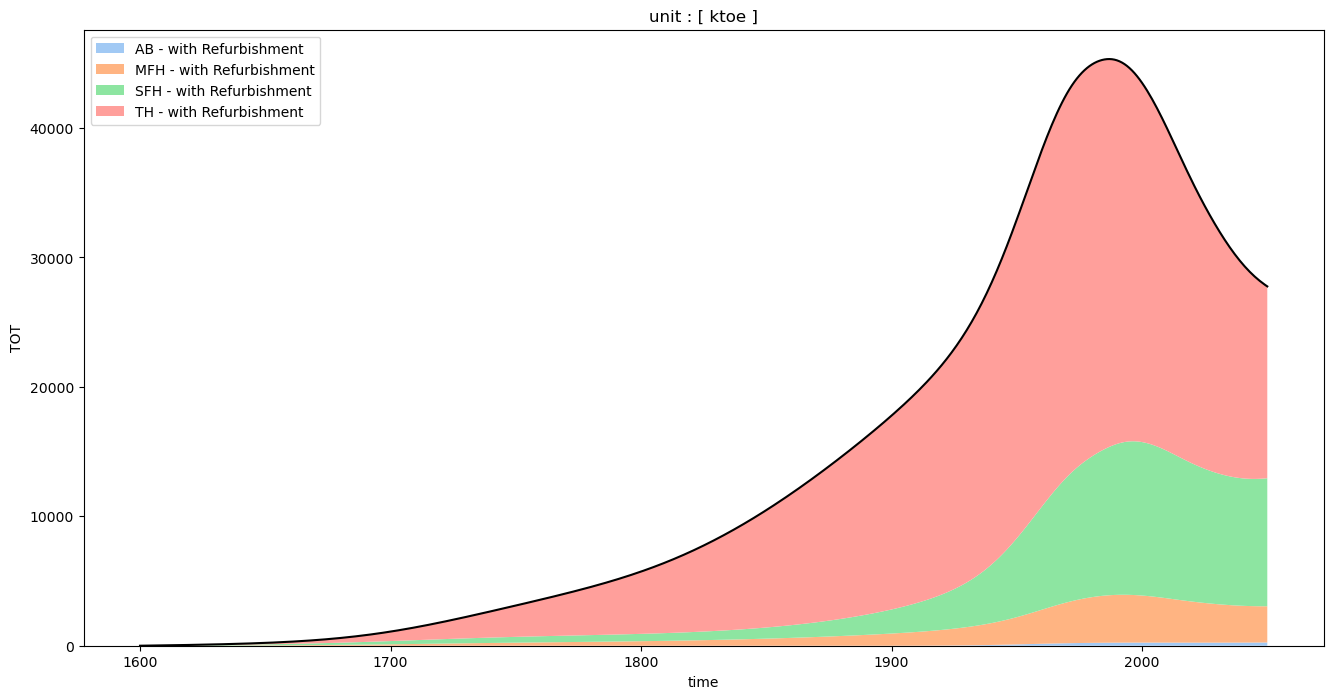

35000
39141.90359413407
48791.089806476724


In [61]:
display(NRJ_Reno_Time_ktoe)

stack_NRJ_Reno_Time_ktoe = [NRJ_Reno_Time_ktoe[k].to_list() for k in TYP[1:]]
lab = [str(k+' - with Refurbishment') for k in TYP[1:]]
colors = sns.color_palette('pastel')[0:4]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_Reno_Time_ktoe.index,stack_NRJ_Reno_Time_ktoe, labels=lab, colors=colors)
sns.lineplot(data=NRJ_Reno_Time_ktoe,x=NRJ_Reno_Time_ktoe.index,y='TOT',color='black')
plt.title('unit : [ ktoe ]')
fig = ax.get_figure()
fig.savefig("Output/Energy/ktoe_per_type_Reno.png",dpi=300,bbox_inches="tight")
plt.show()

MTOE_data = 35000
print(MTOE_data)

print(NRJ_Reno_Time_ktoe.loc[2012,'TOT'])
print(NRJ_AsBuilt_Time_ktoe.loc[2012,'TOT'])

In [62]:
NRJ_Reno_FEC_Time_ktoe = NRJ_Reno_Time_ktoe.copy(deep=True)

NRJ_Reno_FEC_Time_ktoe = ED_to_FEC(NRJ_Reno_FEC_Time_ktoe,NRJ_Reno_Time_ktoe)

display(NRJ_Reno_Time_ktoe)
display(NRJ_Reno_FEC_Time_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,30691.666095,267.656267,3037.553728,10651.622145,16734.833955
2047,30517.843274,268.701293,3034.123281,10661.678597,16553.340103
2048,30354.397401,269.803518,3031.617749,10674.966783,16378.00935


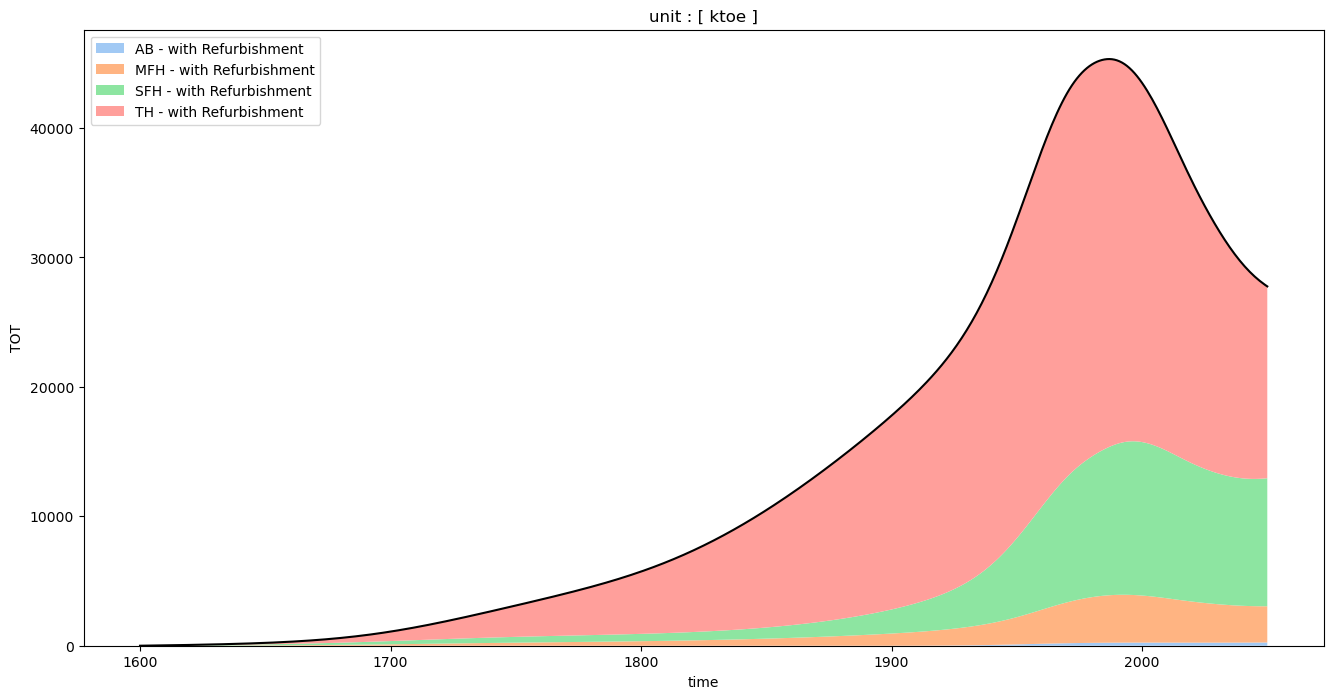

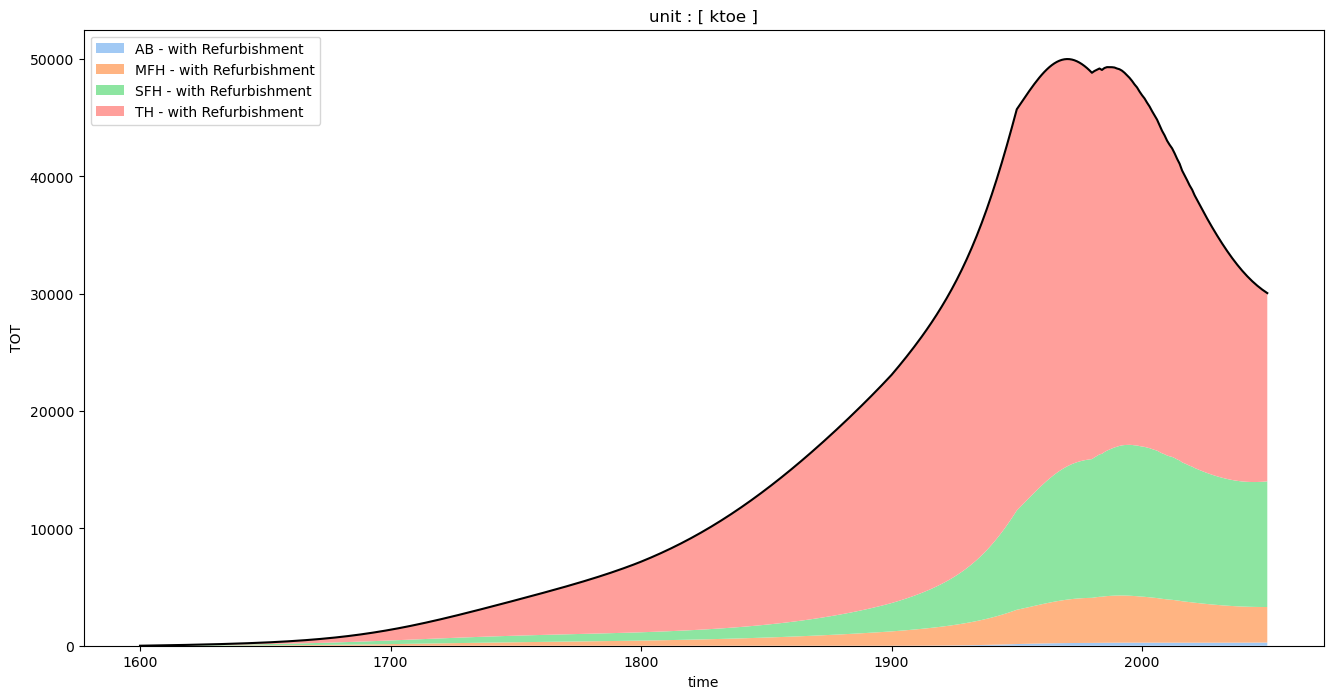

48231.14229101345
34714.28358224146
0.2802516811070942


In [108]:
display_NRJ(NRJ_Reno_Time_ktoe,'ktoe',' - with Refurbishment')
display_NRJ(NRJ_Reno_FEC_Time_ktoe,'ktoe',' - with Refurbishment','Energy/ktoe_per_type_Reno_FEC.png')

print(NRJ_AsBuilt_Time_ktoe.loc[2023,'TOT'])
print(NRJ_Reno_Time_ktoe.loc[2023,'TOT'])

print((NRJ_AsBuilt_Time_ktoe.loc[2023,'TOT']-NRJ_Reno_Time_ktoe.loc[2023,'TOT'])/NRJ_AsBuilt_Time_ktoe.loc[2023,'TOT'])

,Gas,Oil,Coal,Wood,LPG,Renewables
Time,,,,,,
1600,0.185,0.255,0.4075,0.025,0.22,0.03
1601,0.185,0.255,0.4075,0.025,0.22,0.03
1602,0.185,0.255,0.4075,0.025,0.22,0.03
1603,0.185,0.255,0.4075,0.025,0.22,0.03
1604,0.185,0.255,0.4075,0.025,0.22,0.03
...,...,...,...,...,...,...
2046,0.185,0.255,0.4075,0.025,0.22,0.03
2047,0.185,0.255,0.4075,0.025,0.22,0.03
2048,0.185,0.255,0.4075,0.025,0.22,0.03


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,30691.666095,267.656267,3037.553728,10651.622145,16734.833955
2047,30517.843274,268.701293,3034.123281,10661.678597,16553.340103
2048,30354.397401,269.803518,3031.617749,10674.966783,16378.00935


,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,3.239472,0.000000,0.000000
1602,0.000000,0.000000,0.000000,6.532699,0.000000,0.000000
1603,0.000000,0.000000,0.000000,9.889125,0.000000,0.000000
1604,0.000000,0.000000,0.000000,13.308477,0.000000,0.000000
...,...,...,...,...,...,...
2046,26948.127286,1481.019712,329.594404,93.382351,217.892153,1621.650189
2047,26795.506067,1472.631929,327.727740,92.853479,216.658117,1612.465943
2048,26651.996093,1464.744884,325.972513,92.356179,215.497750,1603.829982
2049,26517.287593,1457.341552,324.324934,91.889378,214.408549,1595.723665


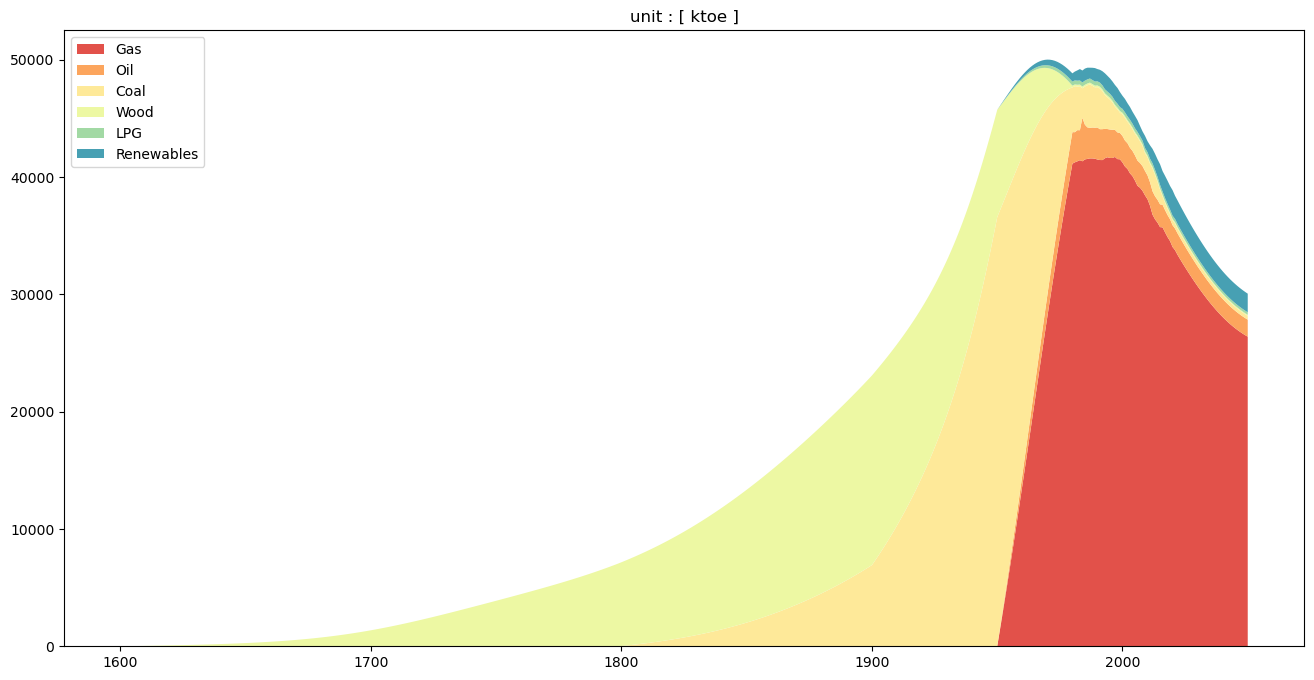

0.3489


,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,0.941876,0.000000,0.000000
1602,0.000000,0.000000,0.000000,1.899382,0.000000,0.000000
1603,0.000000,0.000000,0.000000,2.875263,0.000000,0.000000
1604,0.000000,0.000000,0.000000,3.869440,0.000000,0.000000
...,...,...,...,...,...,...
2046,57980.243262,4392.186108,1562.022041,27.150919,557.498862,565.793751
2047,57651.871078,4367.310881,1553.175500,26.997149,554.341457,562.589367
2048,57343.102193,4343.920665,1544.857083,26.852559,551.372544,559.576281
2049,57053.270121,4321.964972,1537.048836,26.716837,548.585714,556.747987


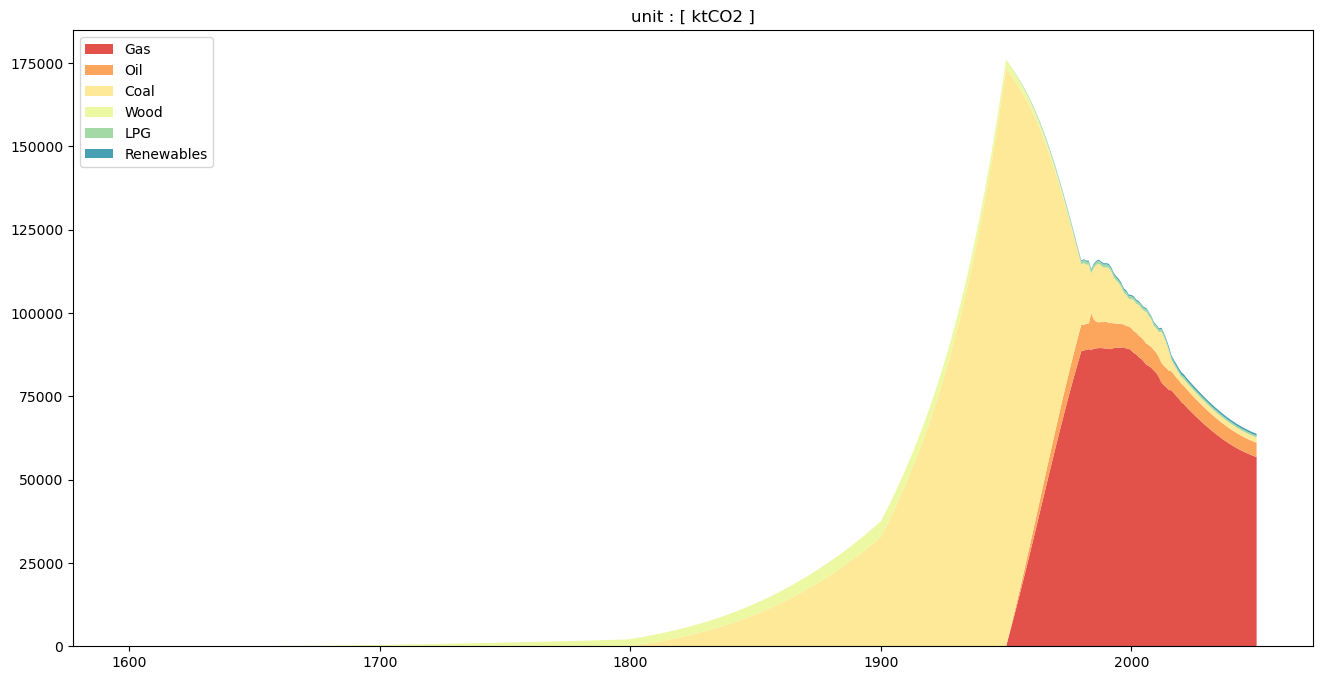

In [109]:
# display(NRJ_FEC) # Share 100%
display(NRJ_CO2) # kCO2/kWh 
display(NRJ_Reno_FEC_Time_ktoe) 

NRJ_FEC_ktoe = NRJ_FEC.copy(deep=True)

for i in NRJ_FEC_ktoe.index:
    for j in NRJ_FEC_ktoe.columns:
        NRJ_FEC_ktoe.loc[i,j] = NRJ_FEC.loc[i,j]*NRJ_Reno_FEC_Time_ktoe.loc[i,'TOT']

display(NRJ_FEC_ktoe)

colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC_ktoe = [NRJ_FEC_ktoe[k].to_list() for k in NRJ_FEC_ktoe.columns]
lab = [str(k) for k in NRJ_FEC_ktoe.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_ktoe.index,stack_NRJ_FEC_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper left')
plt.title('unit : [ ktoe ]')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

NRJ_FEC_CO2 = NRJ_FEC_ktoe.copy(deep=True)

for i in NRJ_FEC_CO2.index:
    for j in NRJ_FEC_CO2.columns:
        co2_ktCO2_per_ktoe = NRJ_CO2.loc[i,j]*11.63
        NRJ_FEC_CO2.loc[i,j] = NRJ_FEC_ktoe.loc[i,j]*co2_ktCO2_per_ktoe

print(co2_ktCO2_per_ktoe)

#display(NRJ_CO2)
display(NRJ_FEC_CO2)

stack_NRJ_FEC_CO2 = [NRJ_FEC_CO2[k].to_list() for k in NRJ_FEC_CO2.columns]
lab = [str(k) for k in NRJ_FEC_CO2.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_CO2.index,stack_NRJ_FEC_CO2, labels=lab, colors=colors)
plt.legend(loc='upper left')
plt.title('unit : [ ktCO2 ]')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,30691.666095,267.656267,3037.553728,10651.622145,16734.833955
2047,30517.843274,268.701293,3034.123281,10661.678597,16553.340103
2048,30354.397401,269.803518,3031.617749,10674.966783,16378.00935


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,0.941876,0.0,0.162822,0.442641,0.336413
1602,1.899382,0.0,0.327147,0.888632,0.683603
1603,2.875263,0.0,0.493411,1.33913,1.042722
1604,3.86944,0.0,0.661557,1.793954,1.413929
...,...,...,...,...,...
2046,65084.894943,567.593169,6441.451066,22587.881222,35487.969486
2047,64716.285432,569.809256,6434.176443,22609.206984,35103.092748
2048,64369.681325,572.146641,6428.8632,22637.385973,34731.285511


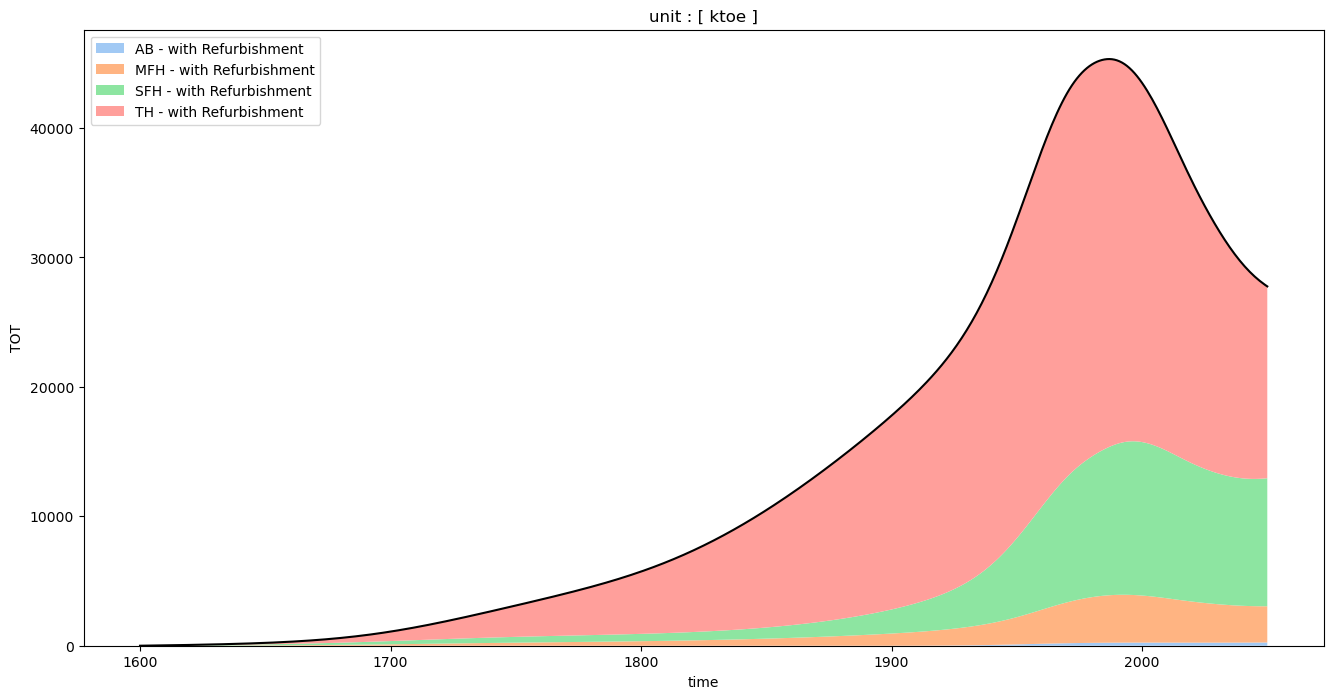

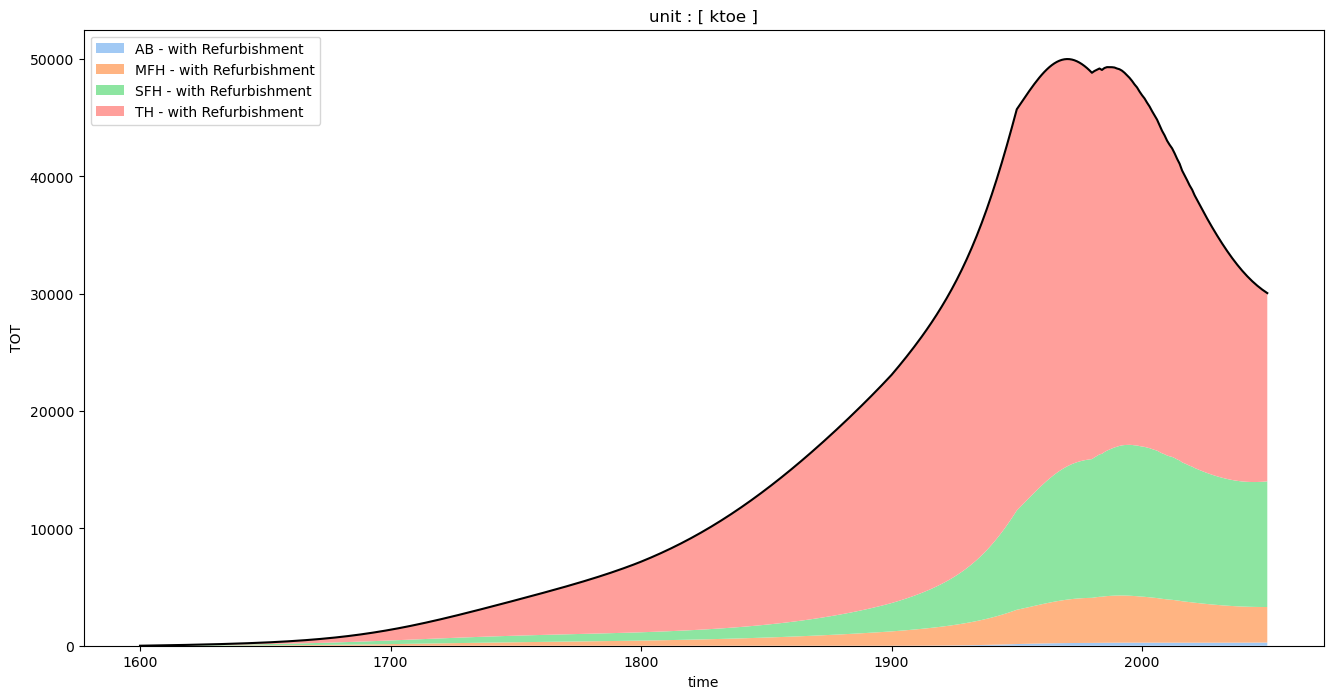

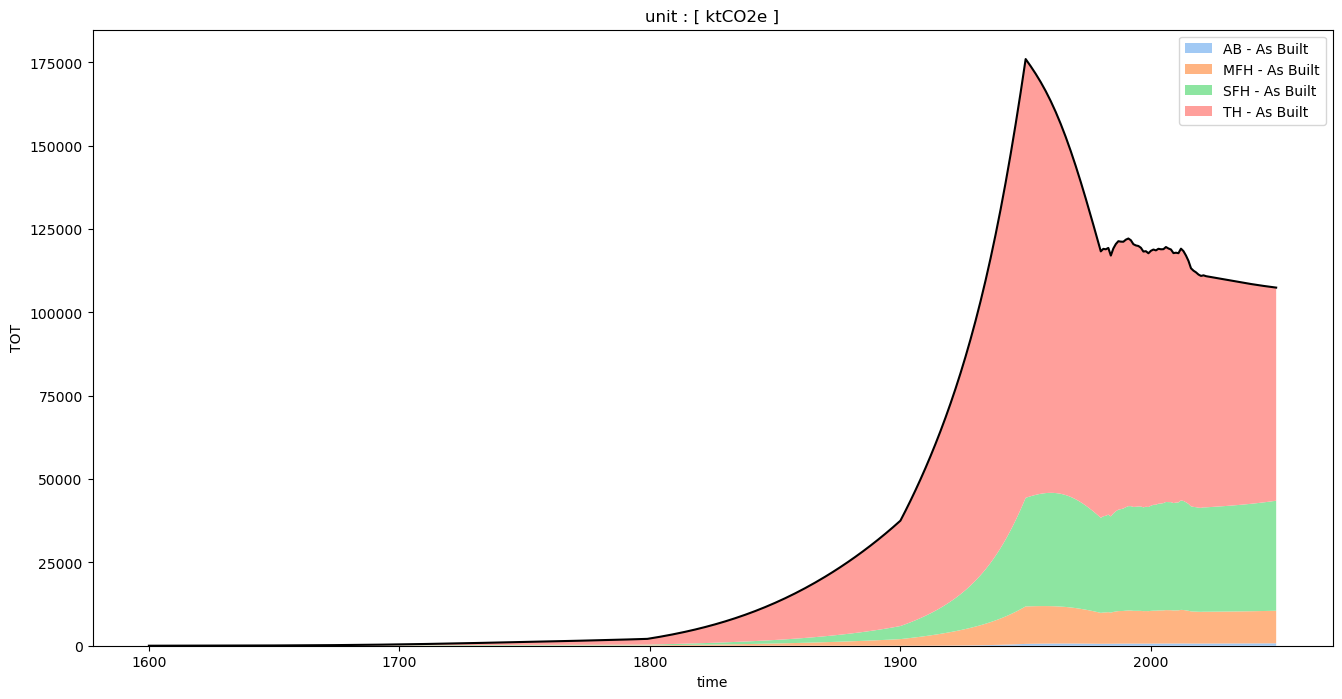

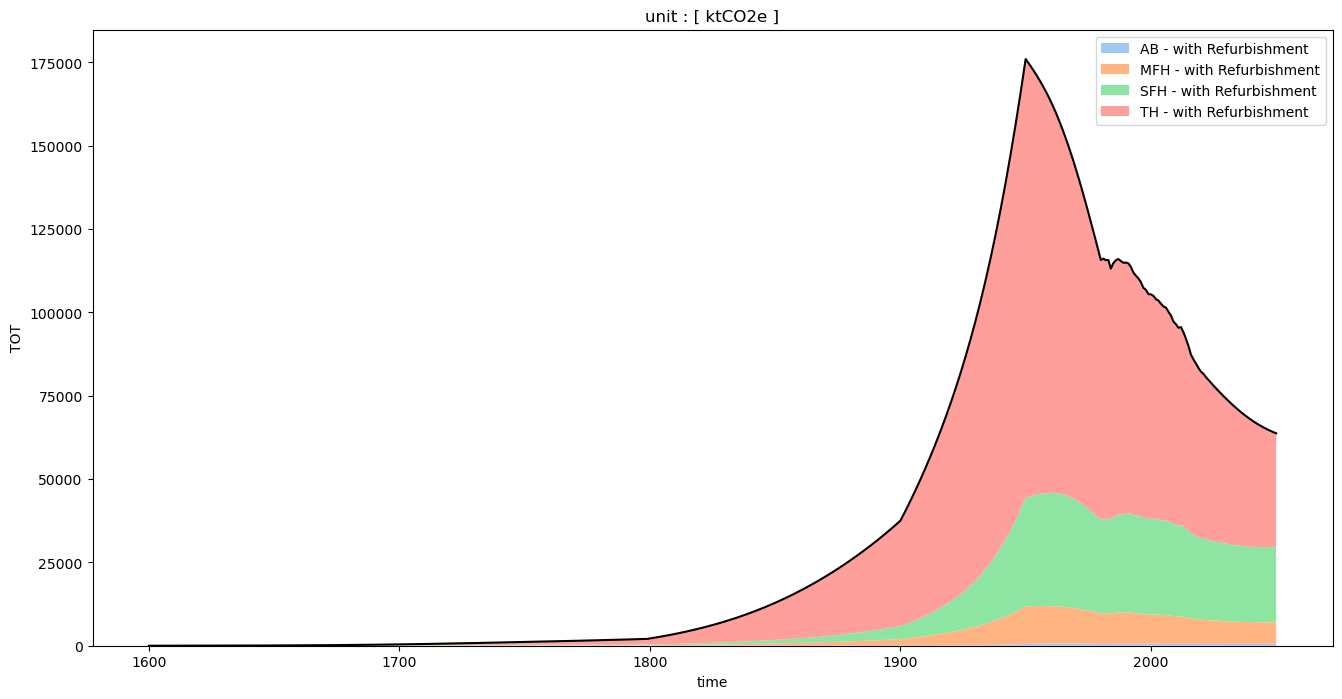

119.14211029962135
95.57993096375603


In [65]:
NRJ_Reno_CO2_Time = NRJ_Reno_FEC_Time_ktoe.copy(deep=True)

NRJ_Reno_CO2_Time = FEC_to_CO2(NRJ_Reno_CO2_Time,NRJ_Reno_FEC_Time_ktoe)

display(NRJ_Reno_FEC_Time_ktoe)
display(NRJ_Reno_CO2_Time)

display_NRJ(NRJ_Reno_Time_ktoe,'ktoe',' - with Refurbishment')
NRJ_Reno_Time_ktoe.to_csv("Model/ED_with_refurbishment_ktoe.csv")
display_NRJ(NRJ_Reno_FEC_Time_ktoe,'ktoe',' - with Refurbishment')
NRJ_Reno_Time_ktoe.to_csv("Model/FEC_with_refurbishment_ktoe.csv")

display_NRJ(NRJ_AsBuilt_CO2_Time,'ktCO2e',' - As Built')
display_NRJ(NRJ_Reno_CO2_Time,'ktCO2e',' - with Refurbishment','Energy/co2_per_type_Reno_FEC.png')
NRJ_Reno_Time_ktoe.to_csv("Model/CO2_with_refurbishment_ktCO2.csv")

print(NRJ_AsBuilt_CO2_Time.loc[2012,'TOT']/1000)
print(NRJ_Reno_CO2_Time.loc[2012,'TOT']/1000)

In [66]:
synthesis_2012 = pd.DataFrame(columns=TYP,index=['Energy Demand As Built (ktoe)','Final Energy Consumption As Built (ktoe)','CO2 emissions As Built (tCO2)','Energy Demand Renovated (ktoe)','Final Energy Consumption Renovated (ktoe)','CO2 emissions Renovated (tCO2)'])

synthesis_2012.loc['Energy Demand As Built (ktoe)',:] = NRJ_AsBuilt_Time_ktoe.loc[2012,:]
synthesis_2012.loc['Final Energy Consumption As Built (ktoe)',:] = NRJ_AsBuilt_FEC_Time_ktoe.loc[2012,:]
synthesis_2012.loc['CO2 emissions As Built (tCO2)',:] = NRJ_AsBuilt_CO2_Time.loc[2012,:]
synthesis_2012.loc['Energy Demand Renovated (ktoe)',:] = NRJ_Reno_Time_ktoe.loc[2012,:]
synthesis_2012.loc['Final Energy Consumption Renovated (ktoe)',:] = NRJ_Reno_FEC_Time_ktoe.loc[2012,:]
synthesis_2012.loc['CO2 emissions Renovated (tCO2)',:] = NRJ_Reno_CO2_Time.loc[2012,:]

display(synthesis_2012)

,TOT,AB,MFH,SFH,TH
Energy Demand As Built (ktoe),48791.089806,275.100409,4131.693064,13447.128925,30937.167408
Final Energy Consumption As Built (ktoe),52851.320088,297.993339,4475.518655,14566.153737,33511.654357
CO2 emissions As Built (tCO2),119142.1103,671.762885,10089.109153,32836.309334,75544.928927
Energy Demand Renovated (ktoe),39141.903594,239.557603,3372.271633,11247.135212,24282.939146
Final Energy Consumption Renovated (ktoe),42399.161075,259.492781,3652.900729,12183.083951,26303.683615
CO2 emissions Renovated (tCO2),95579.930964,584.971528,8234.69122,27464.183098,59296.085117


# Data validation

Careful! All the validation data is from UK numbers => England numbers should be a bit smaller then. 

In [67]:
file = "Data/ONS/ECUK_2022_Primary_Energy_tables.xlsx"
sheet = "Table P2"
validation_FEC = pd.read_excel(file,sheet_name=sheet)

validation_FEC.columns = validation_FEC.loc[4,:]
validation_FEC = validation_FEC.set_index('Year')
validation_FEC.columns.name = None

validation_FEC = pd.DataFrame(validation_FEC["Total - Domestic "])
validation_FEC = validation_FEC.rename(columns={"Total - Domestic ":"Total - Domestic"})
validation_FEC = validation_FEC[validation_FEC.index.notnull()]
validation_FEC = validation_FEC.drop(index=['Return to Title page','Unit','Year'])

display(validation_FEC)

,Total - Domestic
Year,
1970,58015.427211
1971,58028.689811
1972,60633.221105
1973,61898.857647
1974,62528.36692
1975,59917.555426
1976,58023.801471
1977,60181.896323
1978,60359.241779


In [68]:
file = "Data/ONS/final_energy_consumption_DUKES_1.1.5.xlsx"
sheet = "1.1.5 Domestic"
validation_FEC_2 = pd.read_excel(file,sheet_name=sheet)

validation_FEC_2.columns = validation_FEC_2.loc[4,:]
validation_FEC_2 = validation_FEC_2.set_index('Year')
validation_FEC_2.columns.name = None

validation_FEC_2 = pd.DataFrame(validation_FEC_2["Total Domestic [note 4]"])
validation_FEC_2 = pd.DataFrame(validation_FEC_2.loc[1970:2022,:])
validation_FEC_2 = validation_FEC_2.rename(columns={"Total Domestic [note 4]":"Total - Domestic"},index={"1986 [note 11]":1986})

display(validation_FEC_2)

,Total - Domestic
Year,
1970,36884
1971,35621
1972,36261
1973,37576
1974,38002
1975,37062
1976,36634
1977,37898
1978,38689


In [69]:
file = "Data/GOV UK/UK_residential_emissions.xlsx"

validation_emission = pd.read_excel(file)
validation_emission = validation_emission.set_index("Unnamed: 0")
validation_emission.index.name = None
validation_emission = validation_emission.T
validation_emission.index = np.arange(1990,2023)
for i in validation_emission.index:
    validation_emission.loc[i,'Residential combustion'] *= 1000

display(validation_emission)

,Residential combustion
1990,79704.870094
1991,88585.390980
1992,85762.961424
1993,89942.493342
1994,85324.349399
1995,80526.335343
1996,91710.770621
1997,84455.353670
1998,86314.568850
1999,86150.371525


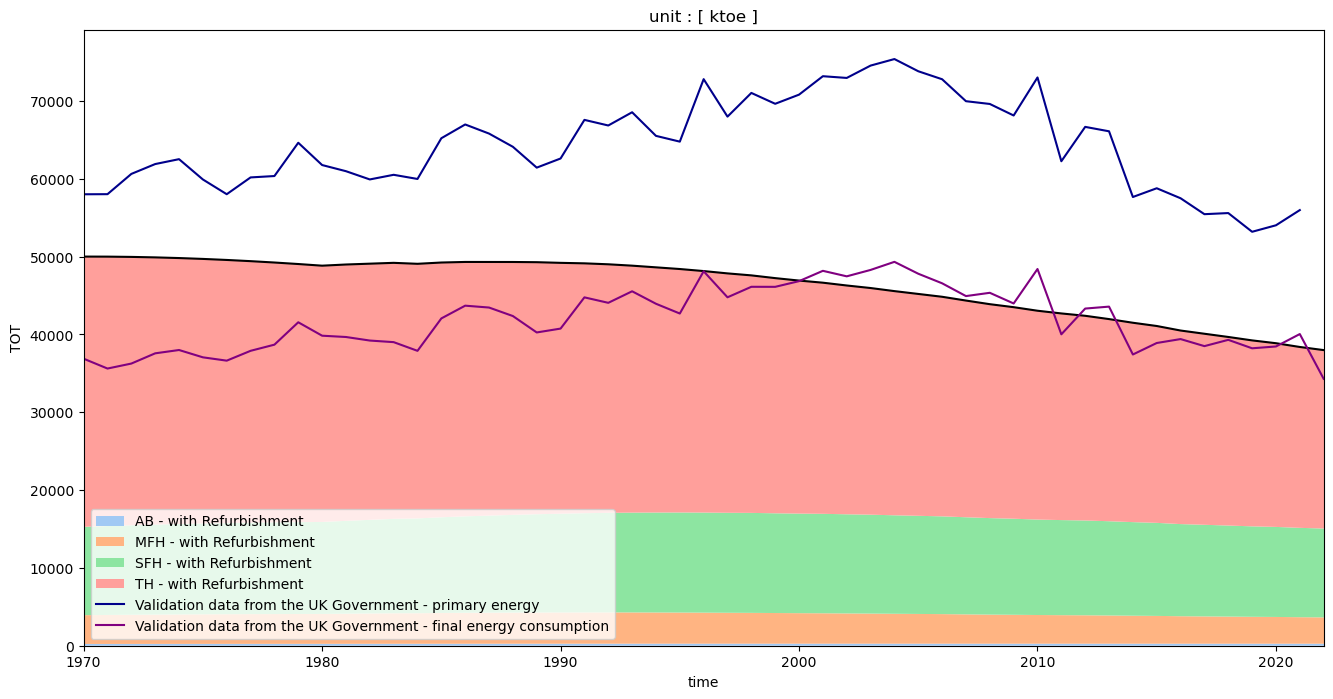

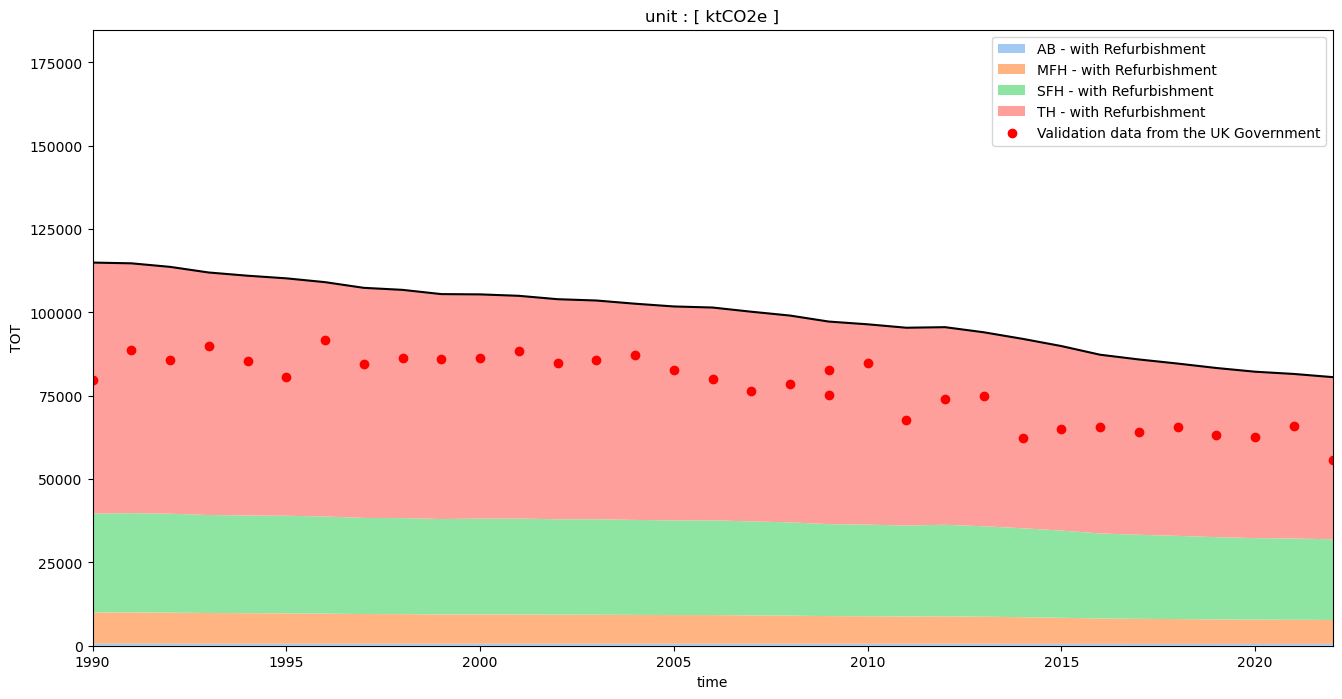

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
[79704.87009369153, 88585.39097974513, 85762.96142445221, 89942.4933417053, 85324.34939885218, 80526.3353434816, 91710.77062102327, 84455.35367047806, 86314.56884988643, 86150.3715251257, 86208.14241417612, 88477.00699868627, 84936.23583994183, 85649.17717877109, 87299.11613770749, 82699.93707238349, 80110.84161294416, 76558.32405206929, 78444.09371738856, 75325.27750735477, 84875.01898665428, 67629.65989201648, 73987.78800264391, 74890.46104856716, 62338.17720658969, 64881.19246238267, 65593.41641181866, 64106.18008307327, 65574.08601542794, 63253.19921918664, 62633.41095394879, 65999.29677173255, 55727.61631241243]


In [70]:
display_NRJ_xlim(NRJ_Reno_FEC_Time_ktoe,'ktoe',' - with Refurbishment',1970,2022)
plt.plot(validation_FEC["Total - Domestic"],label='Validation data from the UK Government - primary energy',color='darkblue')
plt.plot(validation_FEC_2["Total - Domestic"],label='Validation data from the UK Government - final energy consumption',color='purple')
plt.legend()
plt.savefig("Output/Energy/Validation-ktoe.png",dpi=300,bbox_inches='tight')
plt.show()
display_NRJ_xlim(NRJ_Reno_CO2_Time,'ktCO2e',' - with Refurbishment',1990,2022)
# https://assets.publishing.service.gov.uk/media/5a7a4e76e5274a34770e5bb5/4093-emissions-heat-statistical-summary.pdf
plt.scatter([2009],[(64+18.6)*1000],c='r')
plt.scatter(validation_emission.index.to_list(),validation_emission['Residential combustion'].to_list(),c='r',label="Validation data from the UK Government")
plt.legend()
plt.savefig("Output/Energy/Validation-ktCO2.png",dpi=300,bbox_inches='tight')
plt.show()
print(validation_emission.index.to_list())
print(validation_emission['Residential combustion'].to_list())

# CO2 Emission targets ? 

In [71]:
display(NRJ_Reno_CO2_Time)

print(NRJ_Reno_CO2_Time.loc[1990,'TOT'])
print(NRJ_Reno_CO2_Time.loc[2030,'TOT'])
print((NRJ_Reno_CO2_Time.loc[1990,'TOT']-NRJ_Reno_CO2_Time.loc[2030,'TOT'])/NRJ_Reno_CO2_Time.loc[1990,'TOT']*100)
print((NRJ_Reno_CO2_Time.loc[1990,'TOT']-NRJ_Reno_CO2_Time.loc[2022,'TOT'])/NRJ_Reno_CO2_Time.loc[1990,'TOT']*100)
print((validation_emission.loc[1990,'Residential combustion']-validation_emission.loc[2022,'Residential combustion'])/validation_emission.loc[1990,'Residential combustion']*100)

# ALREADY REACHED HERE 

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,0.941876,0.0,0.162822,0.442641,0.336413
1602,1.899382,0.0,0.327147,0.888632,0.683603
1603,2.875263,0.0,0.493411,1.33913,1.042722
1604,3.86944,0.0,0.661557,1.793954,1.413929
...,...,...,...,...,...
2046,65084.894943,567.593169,6441.451066,22587.881222,35487.969486
2047,64716.285432,569.809256,6434.176443,22609.206984,35103.092748
2048,64369.681325,572.146641,6428.8632,22637.385973,34731.285511


114961.20366130251
74130.5061532594
35.51693632952738
29.912252974273617
30.082545461894988


In [73]:
display(NRJ_Reno_CO2_Time)

print(NRJ_Reno_CO2_Time.loc[2018,'TOT'])
print((NRJ_Reno_CO2_Time.loc[2018,'TOT']-NRJ_Reno_CO2_Time.loc[2023,'TOT'])/NRJ_Reno_CO2_Time.loc[2018,'TOT']*100)
print((validation_emission.loc[2018,'Residential combustion']-validation_emission.loc[2022,'Residential combustion'])/validation_emission.loc[2018,'Residential combustion']*100)

# -12.3% since 2018, near from the -13% told by UK GBC 
# BUT THE ROADMAP WAS TARGETTING -19% IN 2023 COMPARED TO 2018 

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,0.941876,0.0,0.162822,0.442641,0.336413
1602,1.899382,0.0,0.327147,0.888632,0.683603
1603,2.875263,0.0,0.493411,1.33913,1.042722
1604,3.86944,0.0,0.661557,1.793954,1.413929
...,...,...,...,...,...
2046,65084.894943,567.593169,6441.451066,22587.881222,35487.969486
2047,64716.285432,569.809256,6434.176443,22609.206984,35103.092748
2048,64369.681325,572.146641,6428.8632,22637.385973,34731.285511


84664.92601902242
5.852571604729207
15.015794045072745


In [74]:
# https://www.iea.org/energy-system/buildings/heating
# do -4% in energy demand until 2030 (IEA)

currently = NRJ_Reno_Time_ktoe['TOT'][2023]
display(currently)
for i in np.arange(2024,2031):
    currently -= 0.04*currently
display(currently)

display(NRJ_Reno_Time_ktoe['TOT'][2030])

# NOT REACHED HERE 

34714.28358224146

26085.96085220685

32284.434023391048